In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

Author: Andrew Tarzia

Date Created: 05 Aug 2018

Distributed under the terms of the MIT License.

# Notebook to analyse all enzymes used in ZIF-8 experiments using BRENDA database

TODO:
- add license
- modifications
    - introduce exposure consideration
        - get another method for calculating exposure without structure?
    - generalise code to multiple target residues ("targ = convert_to_one_letter_code_sing('target_res')" needs to act on a list

In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Alphabet import IUPAC
from rdkit.Chem.Draw import IPythonConsole  # to show molecules in notebook
import time
import numpy as np
import pandas as pd
# ensure cpickle usage
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
from rdkit import Geometry
import tempfile
%aimport pi_fn
%aimport parameters
%aimport BRENDA_IO
%aimport SABIO_IO
%aimport rdkit_functions
%aimport ellipsoid
%aimport DB_functions
%aimport CHEBI_IO
%aimport BKMS_IO
%aimport KEGG_IO
%aimport Uniprot_IO
%aimport PUBCHEM_IO
%aimport rxn_syst

# Calculate pI of all sequences in EC No. used in literature
## Produces distribution for each EC No.

## Notes:
### Biopython:
- pK values and the methods are taken from::
    * Bjellqvist, B.,Hughes, G.J., Pasquali, Ch., Paquet, N., Ravier, F.,
    Sanchez, J.-Ch., Frutiger, S. & Hochstrasser, D.F.
    The focusing positions of polypeptides in immobilized pH gradients can be
    predicted from their amino acid sequences. Electrophoresis 1993, 14,
    1023-1031.
    * Bjellqvist, B., Basse, B., Olsen, E. and Celis, J.E.
    Reference points for comparisons of two-dimensional maps of proteins from
    different human cell types defined in a pH scale where isoelectric points
    correlate with polypeptide compositions. Electrophoresis 1994, 15, 529-539.

|  AA | pKa  |
|-----|------|
| ASP | 4.05 |
| GLU | 4.45 |
| HIS | 5.98 |
| CYS | 9.00 |
| TYR | 10.0 |
| LYS | 10.0 |
| ARG | 12.0 |
| N-terminus | 7.50 |
| N-terminus : GLU | 7.7 |
| N-terminus : VAL | 7.44 |
| N-terminus : THR | 6.82 |
| N-terminus : PRO | 8.36 |
| N-terminus : SER | 6.93 |
| N-terminus : MET | 7.00 |
| N-terminus : ALA | 7.59 |
| C-terminus | 3.55 |
| C-terminus : ASP | 4.55 |
| C-terminus : GLU | 4.75 |

- with the above pKas and the data set in Tash's paper (DOI:) we apply a pI cut off = XX.


### Modified pIs:
- assuming sequence only and therefore cannot use DSSP to calculate exposure

In [3]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [4]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [5]:
# get input FASTA file names
database_names = []
for i in glob.glob(database_directory+"*fasta"):
    if "_mod" not in i:
        database_names.append(i)
database_names = sorted(database_names)
print('databases:')
for i in database_names:
    print('--', i.replace(database_directory, ''))

# prepare output CSV file
redo_pi = input('redo pI calculation (True = yes, False = no)')
if redo_pi == 'True':
    redo_pi = True
    pi_fn.prepare_out_csv(output_dir, param_dict)
    # fix formatting of FASTA files to match BIOPYTHON readable
    pi_fn.fix_fasta(database_names)

databases:
-- 1_11_1_5__BRENDA_sequences.fasta
-- 1_11_1_6__BRENDA_sequences.fasta
-- 1_11_1_7__BRENDA_sequences.fasta
-- 1_13_12_4__BRENDA_sequences.fasta
-- 1_1_3_4__BRENDA_sequences.fasta
-- 1_1_5_2__BRENDA_sequences.fasta
-- 1_9_3_1__BRENDA_sequences.fasta
-- 3_1_1_3__BRENDA_sequences.fasta
-- 3_1_1_6__BRENDA_sequences.fasta
-- 3_2_1_26__BRENDA_sequences.fasta
-- 3_5_1_11__BRENDA_sequences.fasta
-- 3_5_1_5__BRENDA_sequences.fasta
redo pI calculation (True = yes, False = no)False


calculate all pIs for target EC sequences
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
--- finished 2220 sequences in 0.69 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
--- finished 22068 sequences in 7.67 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
--- finished 16288 sequences in 4.23 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_13_12_4__BRENDA_sequences.fasta
--- finished 379 sequences in 0.12 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_3_4__BRENDA_sequences.fasta
--- finished 36 sequences in 0.02 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_5_2__BRENDA_sequences.fasta
--- finished 1765 sequences in 0.67 seconds ---
plot d

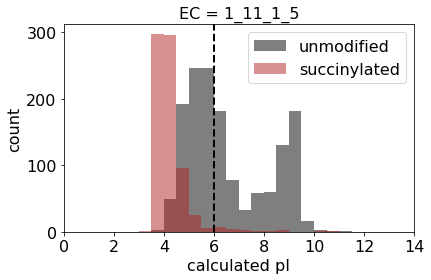

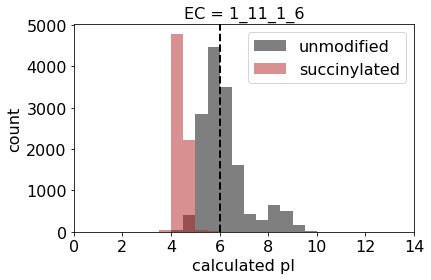

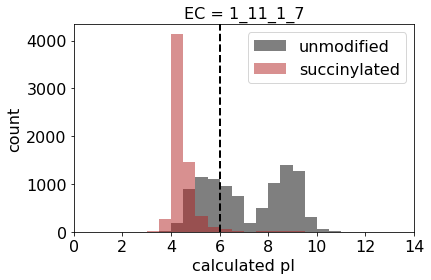

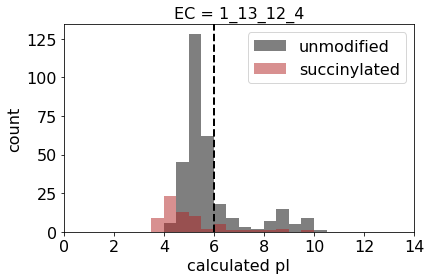

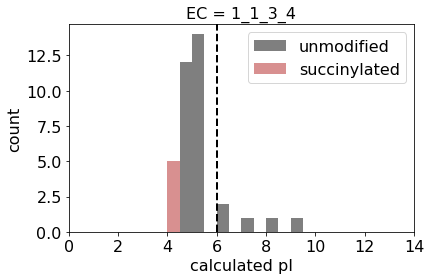

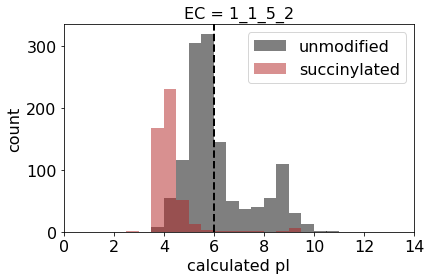

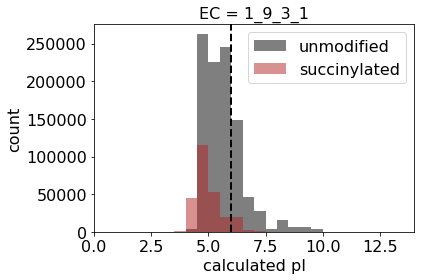

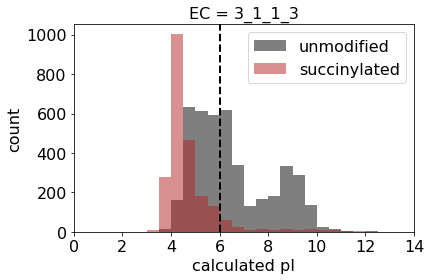

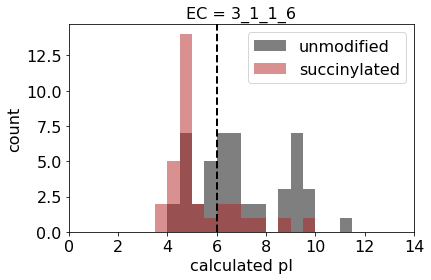

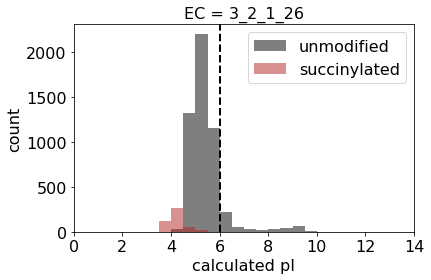

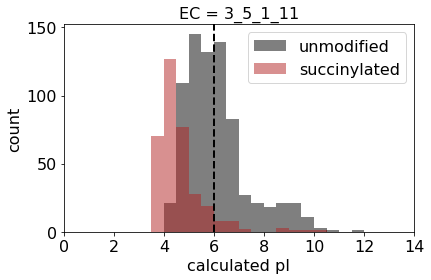

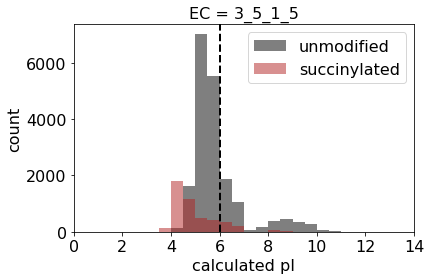

In [9]:
print('calculate all pIs for target EC sequences')
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    if redo_pi is True:
        pi_fn.calculate_pI_from_file(file_mod, param_dict, output_dir)
    print('plot distribution of pIs')
    pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    pi_fn.plot_EC_pI_dist(EC_pi_data, param_dict,
                          filename=file_mod.replace('.fasta', '.pdf'),
                          title=file_mod.replace(output_dir, '').replace('__BRENDA_sequences_mod.fasta', ''))
    print('done')

(0, 30000)

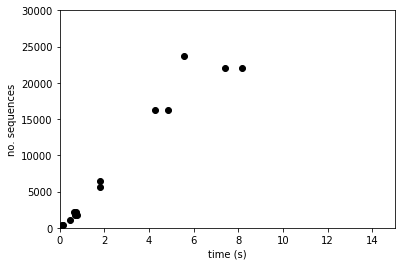

In [10]:
times = [0.74, 8.18, 4.85, 0.13, 0.02, 0.78, 
         0.62, 7.42, 4.26, 0.11, 0.01, 0.67, 
         300.89, 1.81, 0.03, 1.82, 0.44, 5.56]
seqs = [2220, 22068, 16288, 379, 36, 1765, 2220,
        22068, 16288, 379, 36, 1765, 1253592,
        6487, 80, 5665, 1098, 23660]
plt.scatter(times, seqs, c='k')
plt.xlabel('time (s)')
plt.ylabel('no. sequences')
plt.xlim(0, 15)
plt.ylim(0, 30000)

# Collect pI of species used in Literature data base using BRENDA

In [11]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [12]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [13]:
# read in pI output file
pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)

In [14]:
print('Screen all Enzymes in EC Classes using BRENDA data')
count_done = 0
total_start_time = time.time()
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('-----------------------------------------------')
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    # only keep those that pass the pI test
    pi_passed_data = EC_pi_data[EC_pi_data['pi'] < param_dict['cutoff_pi']]
    print('--- ', 
          len(pi_passed_data), 'proteins out of', len(EC_pi_data), 
          'remain, OR', int(len(pi_passed_data)/len(EC_pi_data)*100),
          "% ---")
    EC_no = list(set(EC_pi_data['EC.code']))[0].replace(' ', '').replace(".", "_")
    print('EC:', EC_no.replace("_", "."))
    br_datafile = 'brenda_download_'+EC_no+'.txt'
    # convert br_datafile into dictionary
    br_symbols, br_data = brenda_IO.get_brenda_dict(param_dict['BRENDA_DB_loc']+br_datafile)
    # from here is quite bio-min assay literature specific - although the code can be reused
    # get species of interest from known EC records
    species_of_interest = EC_set[EC_no.replace('_', '.')]
    for spec in species_of_interest:
        print('species:', spec)
        # is species in sequence data?
        spec_in_seq, spec_in_br = brenda_IO.is_species_reported(spec, 
                                                                EC_pi_data, 
                                                                br_data, 
                                                                verbose=True)
        PR_of_int = []
        for i in sorted(br_data['PR']):
            if spec in i.lower():
                # this assumes that the first item of each line is always "#"
                PR_info = i.split("#")[1]            
                if PR_info not in PR_of_int:
                    PR_of_int.append(PR_info)
        # get pI from BRENDA
        prop_of_int = 'PI'
        list_of_int = br_data[prop_of_int]
        # get list of protein codes with property of interest
        EC_prop_PR_codes = brenda_IO.get_prop_PR_codes(list_of_int)
        value_of_int = {}
        for PR in PR_of_int:
            if PR in set([j for i in EC_prop_PR_codes.values() for j in i ]):
                print('protein code:', PR, 'has', prop_of_int, 'in BRENDA')
            else:
                print('protein code:', PR, 'does not have', prop_of_int, 'in BRENDA')
            values = [list_of_int[i].split(" ")[1] 
                      for i in EC_prop_PR_codes.keys() if PR in EC_prop_PR_codes[i]]
            # apply property specific rules
            # check for ranges - append min and max
            values_min = [i.split('-')[0] for i in values if '-' in i and i[0] != '-']
            values_max = [i.split('-')[1] for i in values if '-' in i and i[0] != '-']
            if len(values_min) > 0 and len(values_max) > 0:
                for i in np.arange(len(values)-1, -1, -1):
                    if '-' in values[i]:
                        del values[i]
                print(values_min, values_max)
                values.append(values_min[0])
                values.append(values_max[0])
            # PI == float
            values = [float(i) for i in values]
            # PI => between 0 and 14
            values = [i for i in values if i >= 0 and i <= 14]
            if len(values) > 0:
                value_of_int[PR] = values
        print('reported pIs in BRENDA:', value_of_int.values())
    count_done += 1
print('--- finished %s EC classes in %s seconds ---' % (count_done, '{0:.2f}'.format(time.time() - total_start_time)))

Screen all Enzymes in EC Classes using BRENDA data
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
---  1459 proteins out of 2220 remain, OR 65 % ---
EC: 1.11.1.5
species: equus caballus
species in sequence data: False
species in BRENDA data: False
reported pIs in BRENDA: dict_values([])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
---  14865 proteins out of 22068 remain, OR 67 % ---
EC: 1.11.1.6
species: bos taurus
species in sequence data: True
species in BRENDA data: True
protein code: 12 has PI in BRENDA
protein code: 138 does not have PI in BRENDA
reported pIs in BRENDA: dict_values([[5.4]])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
---  9633 proteins out of 16288 remain, OR 59 % ---
EC: 1.11.1.7
species: armoracia rus

# From the list of reactions reported in the literature - determine, which molecules fit in ZIF-8

In [15]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])


def define_parity_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [16]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_mol_set = {
    # EC : species list : unique molecules
    '1.11.1.5': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
    ]},
    '1.11.1.6': {'bos taurus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('3-amino-1,2,4-triazole', 'C1=NNC(=N1)N'),
    ]},
    '1.11.1.7': {'armoracia rusticana': [
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
    ]},
    '1.9.3.1': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
        ('Amplex Red', 'CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O'),
        ('resorufin', 'C1=CC2=C(C=C1O)OC3=CC(=O)C=CC3=N2'),
        ('methyl ethyl ketone peroxide', 'CCC(C)(OO)OOC(C)(CC)OO'),
        ('tert-butyl hydroperoxide', 'CC(C)(C)OO'),
    ]},
    '1.1.5.2': {'none': [
        ('methosulfate', 'COS(=O)(=O)[O-]'),
        ('5-Methylphenazin-5-ium', 'C[N+]1=C2C=CC=CC2=NC3=CC=CC=C31'),
        ('2,6-dichloroindophenol', 'C1=CC(=O)C=CC1=NC2=CC(=C(C(=C2)Cl)O)Cl'),
    ]},
    '3.5.1.5': {'canavalia ensiformis': [
        ('Urea', 'C(=O)(N)N'),
        ('water', 'O'),
        ('carbon dioxide', 'C(=O)=O'),
        ('ammonia', 'N'),
    ]},
    '1.1.3.4': {'aspergillus niger': [
        ('D-glucose (chain)', 'C(C(C(C(C(C=O)O)O)O)O)O'),
        ('D-glucose (ring)', 'C(C1C(C(C(C(O1)O)O)O)O)O'),
        ('gluconic acid', 'C(C(C(C(C(C(=O)O)O)O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('Gluconolactone', 'C(C1C(C(C(C(=O)O1)O)O)O)O'),
    ]},
    '1.13.12.4': {'none': [
        ('hydrogen peroxide', 'OO'),
        ('pyruvate', 'CC(=O)C(=O)[O-]'),
        ('L-lactate', 'CC(C(=O)[O-])[O-]'),
        
    ]},
    '3.2.1.26': {'none': [
        ('sucrose', 'C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O'),
        ('L-fructose', 'C(C(C(C(C(=O)CO)O)O)O)O'),
        ('D-fructose', 'C1C(C(C(C(O1)(CO)O)O)O)O'),
    ]},
    '3.1.1.3': {'thermomyces lanuginosus': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'alcaligenes sp.': [  # not sure about this one - the kinetic resolution may not belong to this enyzme?
                    ('2-octanol', 'CCCCCCC(C)O'),
                    ('vinyl acetate', 'CC(=O)OC=C'),
                    ('octyl acetate', 'CCCCCCCCOC(=O)C'),
                    ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('octanoic acid', 'CCCCCCCC(=O)O'),
                ],
                'pseudomonas fluorescens': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'rhizomucor miehei': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ], 
                'candida antarctica': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'aspergillus niger': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('acetic acid', 'CC(=O)O'),
                ]},
    '3.1.1.6': {'lactobacillus acidophilus': [
        ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
        ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
        ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('acetic acid', 'CC(=O)O'),
        ('p-nitrophenyl phosphate', 'C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)O'),
        ('phosphate acid', 'OP(=O)([O-])[O-]'),
        ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('butyric acid', 'CCCC(=O)O'),
        ('p-nitrophenyl hexanoate', 'CCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('hexanoic acid', 'CCCCCC(=O)O'),
        ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('octanoic acid', 'CCCCCCCC(=O)O'),
        ('p-nitrophenyl decanoate', 'CCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('decanoic acid', 'CCCCCCCCCC(=O)O'),
        ('p-nitrophenyl dodecanoate', 'CCCCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('dodecanoic acid', 'CCCCCCCCCCCC(=O)O'),
    ]},
    '3.5.1.11': {'none': [
        ('penicillin-G', 'CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C'),
    ]},
    }

In [17]:
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])
# input parameters
database_directory = '/home/atarzia/psp/screening_results/biomin_known/'
output_dir = database_directory

In [18]:
# get all unique molecules and draw 2D structures
molecules = {}
diameters = {}
for i in EC_mol_set.keys():
    for j in EC_mol_set[i].keys():
        for mol in EC_mol_set[i][j]:
            molecules[mol[0]] = mol[1]
            diameters[mol[0]] = 0
            rdkit_functions.draw_smiles_to_svg(mol[1], output_dir+mol[0].replace(' ', '_')+'_2d.svg')

#### calculate size

In [22]:
rdkit_functions.calc_molecule_diameters(molecules, diameters, 
                                        out_dir=output_dir, vdwScale=0.8, boxMargin=4.0,
                                        spacing=0.6, show_vdw=False, plot_ellip=False,
                                        N_conformers=50, MW_thresh=2000,
                                        show_conf=False)

!! calc_molecule_diameters needs documentation !!
molecule: hydrogen peroxide : SMILES: OO
!! calc_molecule_diameter needs documentation !!
1 out of 46 done
molecule: pyrogallol : SMILES: C1=CC(=C(C(=C1)O)O)O
!! calc_molecule_diameter needs documentation !!
2 out of 46 done
molecule: purporogallin : SMILES: C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O
!! calc_molecule_diameter needs documentation !!
3 out of 46 done
molecule: water : SMILES: O
!! calc_molecule_diameter needs documentation !!
4 out of 46 done
molecule: oxygen : SMILES: O=O
!! calc_molecule_diameter needs documentation !!
5 out of 46 done
molecule: 3-amino-1,2,4-triazole : SMILES: C1=NNC(=N1)N
!! calc_molecule_diameter needs documentation !!
6 out of 46 done
molecule: ABTS : SMILES: CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC
!! calc_molecule_diameter needs documentation !!
7 out of 46 done
molecule: Amplex Red : SMILES: CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O
!! calc_molecule_diameter needs doc

#### get results

In [23]:
threshold = float(param_dict['diffuse_threshold'])
diffuse = {}
no_diffuse = {}
count = 0
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    count += 1
    results = pd.read_csv(out_file)
    min_diam = min(results['diam1'])
    mid_diam = min(results['diam2'])
    # print(min(results['diam1']))
    # print(min(results['diam2']))
    # plt.hist(results['diam1'], facecolor='k', alpha=0.4)
    # plt.hist(results['diam2'], facecolor='r', alpha=0.4)
    if mid_diam <= threshold:
        print(name+':')
        print('can diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        diffuse[name] = smile
    else:
        print(name+':')
        print('cannot diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        no_diffuse[name] = smile
    print('-')
print('analyzed ', count, 'molecules')

hydrogen peroxide:
can diffuse
min diameter = 2.758 angstrom
mid diameter = 3.093 angstrom
-
pyrogallol:
cannot diffuse
min diameter = 3.205 angstrom
mid diameter = 7.227 angstrom
-
purporogallin:
cannot diffuse
min diameter = 4.218 angstrom
mid diameter = 8.725 angstrom
-
water:
can diffuse
min diameter = 2.492 angstrom
mid diameter = 2.586 angstrom
-
oxygen:
can diffuse
min diameter = 2.841 angstrom
mid diameter = 2.9 angstrom
-
3-amino-1,2,4-triazole:
cannot diffuse
min diameter = 3.044 angstrom
mid diameter = 5.326 angstrom
-
ABTS:
cannot diffuse
min diameter = 6.284 angstrom
mid diameter = 9.054 angstrom
-
Amplex Red:
cannot diffuse
min diameter = 5.202 angstrom
mid diameter = 10.216 angstrom
-
resorufin:
cannot diffuse
min diameter = 3.403 angstrom
mid diameter = 7.065 angstrom
-
methyl ethyl ketone peroxide:
cannot diffuse
min diameter = 5.76 angstrom
mid diameter = 7.486 angstrom
-
tert-butyl hydroperoxide:
cannot diffuse
min diameter = 5.347 angstrom
mid diameter = 5.816 angst

#### Plot categorical scatter plot

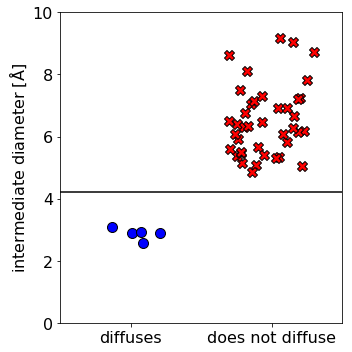

In [24]:
threshold = float(param_dict['diffuse_threshold'])
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.axhline(y=threshold, c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

#### Plot shapes

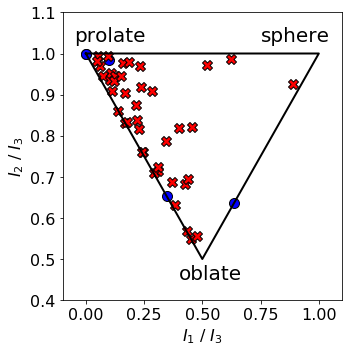

In [25]:
threshold = float(param_dict['diffuse_threshold'])
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(np.average(results['ratio_1']),
               np.average(results['ratio_2']),
               c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.plot([0, 0.5, 1, 0], [1, 0.5, 1, 1], c='k', lw=2)
ax.text(0.75, 1.03, 'sphere', fontsize=20)
ax.text(0.4, 0.45, 'oblate', fontsize=20)
ax.text(-0.05, 1.03, 'prolate', fontsize=20)
define_parity_plot_variables(ax,
                             title='',
                             xtitle='$I_1$ / $I_3$',
                             ytitle='$I_2$ / $I_3$',
                             xlim=(-0.1, 1.1),
                             ylim=(0.4, 1.1))
fig.tight_layout()
fig.savefig(output_dir+"shape.pdf", dpi=720,
            bbox_inches='tight')

# Collect reactant-product systems 
suggest new reactions!

### Collect all reaction systems from multiple databases
Online.

In [3]:
# set output directory
output_dir = '/home/atarzia/psp/screening_results/biomin_search/'

# set databases to search to collect reaction systems
# BKMS should always be last as the culmination of all DBs
Databases = ['BRENDA', 'SABIO', 'KEGG', 'BKMS', ]

# set EC numbers of interest
EC_int = ['1.11.1.5', '1.11.1.6', '1.11.1.7', '1.9.3.1',
          '1.1.5.2', '3.5.1.5', '1.1.3.4', '1.13.12.4',
          '3.2.1.26', '3.1.1.3', '3.1.1.6', '3.5.1.11']

# csv file with molecular output
mol_output_file = output_dir+'screening_output.csv'
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

In [33]:
for DB in Databases:
    # get database specific information
    DB_prop = DB_functions.get_DB_prop(DB)
    db_dir = DB_prop[0]
    # iterate over EC numbers of interest
    for EC in EC_int:
        rxn_syst.get_reaction_systems(EC, DB, output_dir, clean_system=False)

DB: BRENDA - EC: 1.11.1.5 - DB ID: BR1 - 0 of 43
#1# ferrocytochrome c555 + H2O2 = ferricytochrome c555 + OH- <27>

#1# ferrocytochrome c555 + H2O2 = ferricytochrome c555 + OH- <27> 
#1#
 ferrocytochrome c555 + H2O2 = ferricytochrome c555 + OH- <27> 
 ferrocytochrome c555 + H2O2 = ferricytochrome c555 + OH-
 ferrocytochrome c555 + H2O2 ferricytochrome c555 + OH-
['ferrocytochrome c555', 'H2O2'] ['ferricytochrome c555', 'OH-']
no match in DB
ferrocytochrome c555 None
H2O2 16240
no match in DB
ferricytochrome c555 None
OH- 16234
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR2 - 1 of 43
#1,2,3,4,6,7,8,9,10,16,17,18,23,25# ferrocytochrome c + H2O2 =
ferricytochrome c + H2O (#2,4# H2O2 can be substituted by ethyl
peroxide <7>; #2,4# yeast <7>; #1,2,4,6,9,16# horse heart
<2,6,7,26,27>; #23# antioxidant defense <39>; #6# investigation of the
catalytic mechanism <86>)
<2,6,7,23,24,26,27,29,33,34,38,39,40,42,43,68,69,71,72,73,74,75,76,80
82,86>

#1,2,3,4,6,

H2O2 16240
benzoquinone 39439
H2O 15377
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR16 - 15 of 43
#2,4# ferrocyanide + H2O2 = ferricyanide + OH- <7>

#2,4# ferrocyanide + H2O2 = ferricyanide + OH- <7> 
#2,4#
 ferrocyanide + H2O2 = ferricyanide + OH- <7> 
 ferrocyanide + H2O2 = ferricyanide + OH-
 ferrocyanide + H2O2 ferricyanide + OH-
['ferrocyanide', 'H2O2'] ['ferricyanide', 'OH-']
ferrocyanide 5032
H2O2 16240
ferricyanide 5020
OH- 16234
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR17 - 16 of 43
#2,4,14,19,25# more = ? (#2,4# no oxidation of ferrocytochrome c of
bacteria, no mammalian ferrocytochrome b, b5, c1 <7>; #4# Ccp1
functions as a terminal electron acceptor for sulfhydryl oxidase Erv1
<74>; #25# investigation of the binding hot-spot residue Y39 in the
weak protein complex of physiological redox partners 

H2O2 16240
ferricytochrome c 15991
H2O 15377
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR30 - 29 of 43
#4# iso-1 ferrocytochrome c + H2O2 = ? (#4# C102T <72>) <70,72>

#4# iso-1 ferrocytochrome c + H2O2 = ? (#4# C102T <72>) <70,72> 
#4#
 iso-1 ferrocytochrome c + H2O2 = ? ( C102T <72>) <70,72> 
 iso-1 ferrocytochrome c + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR31 - 30 of 43
#4# isoniazid + H2O2 = ? <76>

#4# isoniazid + H2O2 = ? <76> 
#4#
 isoniazid + H2O2 = ? <76> 
 isoniazid + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR32 - 31 of 43
#4# 1-methoxynaphthalene + H2O2 = Russig's blue + 2 H2O <96>

#4# 1-methoxynaphthalene + H2O2 = Russig's blue + 2 H2O <96> 
#4#
 1-methoxynaphthalene + H2O2 = Russig's blue + 2 H2O <96> 
 1-methoxynaphthalene + H2O2 = Russig's blue + 2 H2O
 1-methoxynaphthalene + H2O2 Russig's blue + 2 H2O
['1-methoxynaphthalene',

no match in DB
reduced cytochrome c2 None
H2O2 16240
no match in DB
oxidized cytochrome c2 None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.5 - DB ID: BR43 - 42 of 43
#9# reduced horse cytochrome c + H2O2 = oxidized horse cytochrome c +
H2O <49>

#9# reduced horse cytochrome c + H2O2 = oxidized horse cytochrome c + H2O <49> 
#9#
 reduced horse cytochrome c + H2O2 = oxidized horse cytochrome c + H2O <49> 
 reduced horse cytochrome c + H2O2 = oxidized horse cytochrome c + H2O
 reduced horse cytochrome c + H2O2 oxidized horse cytochrome c + H2O
['reduced horse cytochrome c', 'H2O2'] ['oxidized horse cytochrome c', 'H2O']
no match in DB
reduced horse cytochrome c None
H2O2 16240
no match in DB
oxidized horse cytochrome c None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR1 - 0 of 42
#1,3,5,6,7,8,9,10,11,12,14,15,16,18,19,20,21,22,23,25,26,28,29,30,31,32
33,34,35,38,39,40,42,43,44,45,46,47,48,49,50,51,52,54

H2O2 16240
O2 15379
H2O 15377


RDKit WARNING: [15:24:55]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR2 - 1 of 42
#15,28,31,57# 3,3'-diaminobenzidine + H2O2 = ? + H2O (#15# isoform
Cat-2 <1>) <1,12,17,18>

#15,28,31,57# 3,3'-diaminobenzidine + H2O2 = ? + H2O (#15# isoform Cat-2 <1>) <1,12,17,18> 
#15,28,31,57#
 3,3'-diaminobenzidine + H2O2 = ? + H2O (#15# isoform Cat-2 <1>) <1,12,17,18> 
 3,3'-diaminobenzidine + H2O2 = ? + H2O
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR3 - 2 of 42
#15,57,59,82# o-methoxyphenol + H2O2 = ? + H2O (#15# isoform Cat-2 <1>;
#59# only isoenzyme I has peroxidase activity <14>; #15,57,59,82# i.e.
guaiacol <1,12,14,29>) <1,12,14,29>

#15,57,59,82# o-methoxyphenol + H2O2 = ? + H2O (#15# isoform Cat-2 <1>; #59# only isoenzyme I has peroxidase activity <14>; #15,57,59,82# i.e. guaiacol <1,12,14,29>) <1,12,14,29> 
#15,57,59,82#
 o-methoxyphenol + H2O2 = ? + H2O (#15# isoform Cat-2 <1>; #59# only isoenzyme I has peroxidase activity <14>;  i.e.

H2O2 16240
methanol 17790
formaldehyde 16842
H2O 15377
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR28 - 27 of 42
#43# H2O2 + o-dianisidine = ? + H2O (#43# peroxidase activity <46>) <46>

#43# H2O2 + o-dianisidine = ? + H2O (#43# peroxidase activity <46>) <46> 
#43#
 H2O2 + o-dianisidine = ? + H2O ( peroxidase activity <46>) <46> 
 H2O2 + o-dianisidine = ? + H2O
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR29 - 28 of 42
#45,64# beta-(3,4-dihydroxyphenyl)-L-alanine + H2O2 = ? + H2O (#64# low
activity <19>) {} <19,28>

#45,64# beta-(3,4-dihydroxyphenyl)-L-alanine + H2O2 = ? + H2O (#64# low activity <19>) {} <19,28> 
#45,64#
 beta-(3,4-dihydroxyphenyl)-L-alanine + H2O2 = ? + H2O (#64# low activity <19>) {} <19,28> 
 beta-(3,4-dihydroxyphenyl)-L-alanine + H2O2 = ? + H2O
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR30 - 29 of 42
#45,64# beta-(3,4-dihydroxyphenyl)-L-alanine +

RDKit WARNING: [15:25:03]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR32 - 31 of 42
#57# 3,3'-dimethoxybenzidine + H2O2 = ? + H2O <12>

#57# 3,3'-dimethoxybenzidine + H2O2 = ? + H2O <12> 
#57#
 3,3'-dimethoxybenzidine + H2O2 = ? + H2O <12> 
 3,3'-dimethoxybenzidine + H2O2 = ? + H2O
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR33 - 32 of 42
#57# 2,6-dimethoxyphenol + H2O2 = ? + H2O <12>

#57# 2,6-dimethoxyphenol + H2O2 = ? + H2O <12> 
#57#
 2,6-dimethoxyphenol + H2O2 = ? + H2O <12> 
 2,6-dimethoxyphenol + H2O2 = ? + H2O
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR34 - 33 of 42
#57,59# 2,2'-azinobis(3-ethylbenzothiazoline-6-sulfonic acid) + H2O2 =
? + H2O (#59# only isoenzyme I has peroxidase activity <14>) <12,14>

#57,59# 2,2'-azinobis(3-ethylbenzothiazoline-6-sulfonic acid) + H2O2 = ? + H2O (#59# only isoenzyme I has peroxidase activity <14>) <12,14> 
#57,59#
 2,2'-azinobis(3-ethylbenzothiazo

H2O2 16240
O2 15379
H2O 15377


RDKit WARNING: [15:25:04]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR37 - 36 of 42
#8,15,28,31# o-dianisidine + H2O2 = ? + H2O (#15# isoform Cat-2 <1>;
#8# peroxidatic activity <30>) <1,17,18,30>

#8,15,28,31# o-dianisidine + H2O2 = ? + H2O (#15# isoform Cat-2 <1>; #8# peroxidatic activity <30>) <1,17,18,30> 
#8,15,28,31#
 o-dianisidine + H2O2 = ? + H2O (#15# isoform Cat-2 <1>; #8# peroxidatic activity <30>) <1,17,18,30> 
 o-dianisidine + H2O2 = ? + H2O
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR38 - 37 of 42
#8,15,28,31,39,47# ascorbate + H2O2 = ? + H2O (#15# isoform Cat-2 <1>)
<1,17,20>

#8,15,28,31,39,47# ascorbate + H2O2 = ? + H2O (#15# isoform Cat-2 <1>) <1,17,20> 
#8,15,28,31,39,47#
 ascorbate + H2O2 = ? + H2O (#15# isoform Cat-2 <1>) <1,17,20> 
 ascorbate + H2O2 = ? + H2O
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.6 - DB ID: BR39 - 38 of 42
#82# catechol + H2O2 = ? + H2O <29>

#82# catechol + H2

H2O2 16240
dehydroascorbate 17242
H2O 15377
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR11 - 10 of 270
#19# eugenol + H2O2 = ? <23>

#19# eugenol + H2O2 = ? <23> 
#19#
 eugenol + H2O2 = ? <23> 
 eugenol + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR12 - 11 of 270
#19,40,46,59,87# 4-aminoantipyrine + H2O2 = ? (#40# 643% activity
compared to guaiacol <106>) <11,22,23,106,115>

#19,40,46,59,87# 4-aminoantipyrine + H2O2 = ? (#40# 643% activity compared to guaiacol <106>) <11,22,23,106,115> 
#19,40,46,59,87#
 4-aminoantipyrine + H2O2 = ? (#40# 643% activity compared to guaiacol <106>) <11,22,23,106,115> 
 4-aminoantipyrine + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR13 - 12 of 270
#2,85,86# 3,3',5,5'-tetramethylbezidine + H2O2 = ? <113>

#2,85,86# 3,3',5,5'-t

H2O2 16240
no match in DB
OSCN- None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR31 - 30 of 270
#26# o-coumaric acid + H2O2 = ? <73>

#26# o-coumaric acid + H2O2 = ? <73> 
#26#
 o-coumaric acid + H2O2 = ? <73> 
 o-coumaric acid + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR32 - 31 of 270
#27,39,40,52# guaiacol + H2O2 = ? (#40# 100% activity <106>; #39#
isoenzyme POX I <74>; #39# isoenzyme POX II <74>) <74,75,106,147>

#27,39,40,52# guaiacol + H2O2 = ? (#40# 100% activity <106>; #39# isoenzyme POX I <74>; #39# isoenzyme POX II <74>) <74,75,106,147> 
#27,39,40,52#
 guaiacol + H2O2 = ? (#40# 100% activity <106>; #39# isoenzyme POX I <74>; #39# isoenzyme POX II <74>) <74,75,106,147> 
 guaiacol + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR33 - 32 of 270
#28# guaiacol + H2O2 = oxidized guaiacol + H2O <44>

#28# guaiacol + H2O2 = oxidized guaiaco

Cl- 17996
H2O2 16240
HOCl 24757
H2O 15377
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR54 - 53 of 270
#4# L-ascorbate + H2O2 = dehydroascorbate + H2O <121>

#4# L-ascorbate + H2O2 = dehydroascorbate + H2O <121> 
#4#
 L-ascorbate + H2O2 = dehydroascorbate + H2O <121> 
 L-ascorbate + H2O2 = dehydroascorbate + H2O
 L-ascorbate + H2O2 dehydroascorbate + H2O
['L-ascorbate', 'H2O2'] ['dehydroascorbate', 'H2O']
L-ascorbate 38290
H2O2 16240
dehydroascorbate 17242
H2O 15377
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR55 - 54 of 270
#4# Cl- + H2O2 = ? <59>

#4# Cl- + H2O2 = ? <59> 
#4#
 Cl- + H2O2 = ? <59> 
 Cl- + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR56 - 55 of 270
#4# West Pico + H2O2 = ? <121>

#4# West Pico + H2O2 = ? <121> 
#4#
 West Pico + H2O2 = ? <121> 
 West P

H2O2 16240
purpurogallin 8647
H2O 15377
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR64 - 63 of 270
#4,9,19,33,46,55,58# 2,2'-azino-bis(3-ethylbenzthiazole-6-sulfonic
acid) + H2O2 = ? <2,8,11,19,20,32>

#4,9,19,33,46,55,58# 2,2'-azino-bis(3-ethylbenzthiazole-6-sulfonic acid) + H2O2 = ? <2,8,11,19,20,32> 
#4,9,19,33,46,55,58#
 2,2'-azino-bis(3-ethylbenzthiazole-6-sulfonic acid) + H2O2 = ? <2,8,11,19,20,32> 
 2,2'-azino-bis(3-ethylbenzthiazole-6-sulfonic acid) + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR65 - 64 of 270
#40# 2,6-dimethoxyphenol + H2O2 = ? <106>

#40# 2,6-dimethoxyphenol + H2O2 = ? <106> 
#40#
 2,6-dimethoxyphenol + H2O2 = ? <106> 
 2,6-dimethoxyphenol + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR66 - 65 of 270
#40# ABTS + H2O2 = ? (#40# 89% activity compared to guaiacol <106>)
<106>

#40# ABTS + H2O2 = ? (#40# 89% activity compared to

H2O2 16240
no match in DB
5,5'-dicapsaicin None
no match in DB
4'-O-5-dicapsaicin ether None
no match in DB
capsaicin polymers None
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR108 - 107 of 270
#52# dihydrocapsaicin + H2O2 = 5,5-didihydrocapsaicin +
4'-O-5-didihydrocapsaicin ether + dihydrocapsaicin polymers <35>

#52# dihydrocapsaicin + H2O2 = 5,5-didihydrocapsaicin + 4'-O-5-didihydrocapsaicin ether + dihydrocapsaicin polymers <35> 
#52#
 dihydrocapsaicin + H2O2 = 5,5-didihydrocapsaicin + 4'-O-5-didihydrocapsaicin ether + dihydrocapsaicin polymers <35> 
 dihydrocapsaicin + H2O2 = 5,5-didihydrocapsaicin + 4'-O-5-didihydrocapsaicin ether + dihydrocapsaicin polymers
 dihydrocapsaicin + H2O2 5,5-didihydrocapsaicin + 4'-O-5-didihydrocapsaicin ether + dihydrocapsaicin polymers
['dihydrocapsaicin', 'H2O2'] ['5,5-didihydrocapsaicin', "4'-O-5-didihydrocapsaicin ether", 'dihydrocapsaicin polymers']
dihydrocapsaicin 46932
H2O2 16240
no match in DB
5,5-didih

H2O2 16240
no match in DB
2-amino-9,10a-dihydro-3H-phenoxazin-3-one ir None
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR134 - 133 of 270
#52#
2-[(1Z,3Z)-4-[4-(dimethylamino)phenyl]buta-1,3-dien-1-yl]-3-propyl-1
3-benzothiazol-3-ium iodide + H2O2 = ? <97>

#52# 2-[(1Z,3Z)-4-[4-(dimethylamino)phenyl]buta-1,3-dien-1-yl]-3-propyl-1 3-benzothiazol-3-ium iodide + H2O2 = ? <97> 
#52#
 2-[(1Z,3Z)-4-[4-(dimethylamino)phenyl]buta-1,3-dien-1-yl]-3-propyl-1 3-benzothiazol-3-ium iodide + H2O2 = ? <97> 
 2-[(1Z,3Z)-4-[4-(dimethylamino)phenyl]buta-1,3-dien-1-yl]-3-propyl-1 3-benzothiazol-3-ium iodide + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR135 - 134 of 270
#52#
2-[(E)-2-[4-(diethylamino)phenyl]ethenyl]-3-propyl-1
3-benzothiazol-3-ium iodide + H2O2 = ? <97>

#52# 2-[(E)-2-[4-(diethylamino)phenyl]ethenyl]-3-propyl-1 3-benzothiazol-3-ium iodide + H2O2 = ? <97> 
#52#
 2-[(E)-2-[4-(diethylamino)phenyl]ethenyl]-3

p-phenylenediamine 51403
H2O2 16240
no match in DB
cyclohexa-2,5-diene-1,4-diimine None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR203 - 202 of 270
#52# p-phenylenediamine + H2O2 = benzene-1,4-diamine + H2O <104>

#52# p-phenylenediamine + H2O2 = benzene-1,4-diamine + H2O <104> 
#52#
 p-phenylenediamine + H2O2 = benzene-1,4-diamine + H2O <104> 
 p-phenylenediamine + H2O2 = benzene-1,4-diamine + H2O
 p-phenylenediamine + H2O2 benzene-1,4-diamine + H2O
['p-phenylenediamine', 'H2O2'] ['benzene-1,4-diamine', 'H2O']
p-phenylenediamine 51403
H2O2 16240
benzene-1,4-diamine 51403
H2O 15377
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR204 - 203 of 270
#52# 2-chlorophenol + H2O2 = ? (#52# optimal concentrations of
2-chlorophenol and H2O2 are 0.2 mM and 0.3 mM, respectively <139>) {r}
<139>

#52# 2-chlorophenol + H2O2 = ? (#52# optimal concentrations of 2-chlorophenol and H2O2 are 0.2 mM and 0.3 mM, respect

no match in DB
trans-beta-methylstyrene None
H2O2 16240
no match in DB
trans-beta-methylstyrene oxide None
benzaldehyde 17169
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR220 - 219 of 270
#59# 2,4-dibromophenol + H2O2 = ? <22>

#59# 2,4-dibromophenol + H2O2 = ? <22> 
#59#
 2,4-dibromophenol + H2O2 = ? <22> 
 2,4-dibromophenol + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR221 - 220 of 270
#59# 2,4,6-trichlorophenol + H2O2 = ? <22>

#59# 2,4,6-trichlorophenol + H2O2 = ? <22> 
#59#
 2,4,6-trichlorophenol + H2O2 = ? <22> 
 2,4,6-trichlorophenol + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR222 - 221 of 270
#59# pyrocatechol + H2O2 = ? <22>

#59# pyrocatechol + H2O2 = ? <22> 
#59#
 pyrocatechol + H2O2 = ? <22> 
 pyrocatechol + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR223 - 222 of 270
#59# sodium

H2O2 16240
no match in DB
oxidized electron donor None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR244 - 243 of 270
#7,52# electron donor + H2O2 = oxidized electron donor + H2O (#7# LPO
also has pseudo-catalase activity <36>) <36,130>

#7,52# electron donor + H2O2 = oxidized electron donor + H2O (#7# LPO also has pseudo-catalase activity <36>) <36,130> 
#7,52#
 electron donor + H2O2 = oxidized electron donor + H2O (#7# LPO also has pseudo-catalase activity <36>) <36,130> 
 electron donor + H2O2 = oxidized electron donor + H2O
 electron donor + H2O2 oxidized electron donor + H2O
['electron donor', 'H2O2'] ['oxidized electron donor', 'H2O']
electron donor 15022
H2O2 16240
no match in DB
oxidized electron donor None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR245 - 244 of 270
#7,61# 2,2-azino-bis-(3-ethylbenz-thiazoline-6-sulfonic acid) + H2O2 =
? + H2O <87,102>

#7,61# 2,2-azino-bis-(3-eth

H2O2 16240
NAD+ 15846
H2O 15377
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR257 - 256 of 270
#84# NADPH + H2O2 = NADP+ + H2O <124>

#84# NADPH + H2O2 = NADP+ + H2O <124> 
#84#
 NADPH + H2O2 = NADP+ + H2O <124> 
 NADPH + H2O2 = NADP+ + H2O
 NADPH + H2O2 NADP+ + H2O
['NADPH', 'H2O2'] ['NADP+', 'H2O']
NADPH 16474
H2O2 16240
NADP+ 18009
H2O 15377
skip? False
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR258 - 257 of 270
#90# thiocyanate + H2O2 = hypothiocyanate + H2O <110>

#90# thiocyanate + H2O2 = hypothiocyanate + H2O <110> 
#90#
 thiocyanate + H2O2 = hypothiocyanate + H2O <110> 
 thiocyanate + H2O2 = hypothiocyanate + H2O
 thiocyanate + H2O2 hypothiocyanate + H2O
['thiocyanate', 'H2O2'] ['hypothiocyanate', 'H2O']
thiocyanate 18022
H2O2 16240
no match in DB
hypothiocyanate None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.11.1.7 - DB ID: BR259 - 258 of 270
#92# benzhydroxamic acid + H2O2 =

no match in DB
reduced Bos taurus cytochrome c None
O2 15379
no match in DB
oxidized Bos taurus cytochrome c None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR3 - 2 of 55
#13,14,17,21,26,46,53,79,85,86,87,88,100# more = ? (#21# the
predominant entry point for protons going into the K-channel of
cytochrome oxidase is the surface-exposed glutamic acid E101 in subunit
II <148>; #14# thyroid hormone T3 regulates the expression of COX
subunits by both transcriptional and posttranslational mechanism <143>;
#85,86,87,88# antioxidant enzyme activities may not be enhanced as part
of adaptation in arctic fishes, at least not in the liver <175>;
#13,26,46# accessibility and electrostatic charge of enzyme do not
differ in a significant way among human, Arabidopsis thaliana and horse
<166>; #100# For all mutant strains, the NADH oxidation activity of
membranes obtained from aerobic exponentially growing cultures is some
higher than that of the wild-ty

NO 16480
no match in DB
O22- None
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR9 - 8 of 55
#17# benzidine + H2O2 = ? <199>

#17# benzidine + H2O2 = ? <199> 
#17#
 benzidine + H2O2 = ? <199> 
 benzidine + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR10 - 9 of 55
#17# p-phenylenediamine + H2O2 = ? <199>

#17# p-phenylenediamine + H2O2 = ? <199> 
#17#
 p-phenylenediamine + H2O2 = ? <199> 
 p-phenylenediamine + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR11 - 10 of 55
#17# tetramethylbenzidine + H2O2 = ? <199>

#17# tetramethylbenzidine + H2O2 = ? <199> 
#17#
 tetramethylbenzidine + H2O2 = ? <199> 
 tetramethylbenzidine + H2O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR12 - 11 of 55
#17# amidopyrine + H2O2 = ? <199>

#17# amidopyrine + H2O2 = ? <199> 
#17#
 amidopyrine + H2O2 = ? <199> 
 amidopyrine + H2O2 = ?
skip?

no match in DB
reduced Homo sapiens cytochrome c None
O2 15379
no match in DB
oxidized Homo sapiens cytochrome c None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR24 - 23 of 55
#27# reduced horse cytochrome c + O2 = oxidized horse cytochrome c +
H2O <163>

#27# reduced horse cytochrome c + O2 = oxidized horse cytochrome c + H2O <163> 
#27#
 reduced horse cytochrome c + O2 = oxidized horse cytochrome c + H2O <163> 
 reduced horse cytochrome c + O2 = oxidized horse cytochrome c + H2O
 reduced horse cytochrome c + O2 oxidized horse cytochrome c + H2O
['reduced horse cytochrome c', 'O2'] ['oxidized horse cytochrome c', 'H2O']
no match in DB
reduced horse cytochrome c None
O2 15379
no match in DB
oxidized horse cytochrome c None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR25 - 24 of 55
#27# reduced Kloeckera sp. cytochrome c + O2 = oxidized Kloeckera sp.
cytochrome c + H2O (#27# relative activit

no match in DB
reduced Pseudomonas aeruginosa cytochrome c None
O2 15379
no match in DB
oxidized Pseudomonas aeruginosa cytochrome c None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR34 - 33 of 55
#27# reduced Pseudomonas saccharophila cytochrome c + O2 = oxidized
Pseudomonas saccharophila cytochrome c + H2O (#27# relative activity
82% <165>) <165>

#27# reduced Pseudomonas saccharophila cytochrome c + O2 = oxidized Pseudomonas saccharophila cytochrome c + H2O (#27# relative activity 82% <165>) <165> 
#27#
 reduced Pseudomonas saccharophila cytochrome c + O2 = oxidized Pseudomonas saccharophila cytochrome c + H2O ( relative activity 82% <165>) <165> 
 reduced Pseudomonas saccharophila cytochrome c + O2 = oxidized Pseudomonas saccharophila cytochrome c + H2O
 reduced Pseudomonas saccharophila cytochrome c + O2 oxidized Pseudomonas saccharophila cytochrome c + H2O
['reduced Pseudomonas saccharophila cytochrome c', 'O2'] ['oxidized Pseudomon

H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR43 - 42 of 55
#3,13,164,165,166,167# ferricytochrome c + H2O = ferrocytochrome c + O2
+ H+ <262,263,265,266>

#3,13,164,165,166,167# ferricytochrome c + H2O = ferrocytochrome c + O2 + H+ <262,263,265,266> 
#3,13,164,165,166,167#
 ferricytochrome c + H2O = ferrocytochrome c + O2 + H+ <262,263,265,266> 
 ferricytochrome c + H2O = ferrocytochrome c + O2 + H+
 ferricytochrome c + H2O ferrocytochrome c + O2 + H+
['ferricytochrome c', 'H2O'] ['ferrocytochrome c', 'O2', 'H+']
ferricytochrome c 15991
H2O 15377
ferrocytochrome c 16928
O2 15379
H+ 15378


RDKit WARNING: [15:26:47]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR44 - 43 of 55
#4# 2,3,5,6-tetramethyl-p-phenylendiamine + O2 + H+ = ? + H2O {} <205>

#4# 2,3,5,6-tetramethyl-p-phenylendiamine + O2 + H+ = ? + H2O {} <205> 
#4#
 2,3,5,6-tetramethyl-p-phenylendiamine + O2 + H+ = ? + H2O {} <205> 
 2,3,5,6-tetramethyl-p-phenylendiamine + O2 + H+ = ? + H2O {}
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR45 - 44 of 55
#4,13# reduced horse cytochrome c + O2 + H+ = oxidized horse cytochrome
c + H2O <202,205>

#4,13# reduced horse cytochrome c + O2 + H+ = oxidized horse cytochrome c + H2O <202,205> 
#4,13#
 reduced horse cytochrome c + O2 + H+ = oxidized horse cytochrome c + H2O <202,205> 
 reduced horse cytochrome c + O2 + H+ = oxidized horse cytochrome c + H2O
 reduced horse cytochrome c + O2 + H+ oxidized horse cytochrome c + H2O
['reduced horse cytochrome c', 'O2', 'H+'] ['oxidized horse cytochrome c', 'H2O']
no match in DB
reduced h

O2 15379
ferricytochrome c 15991
H2O 15377


RDKit WARNING: [15:26:51]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR47 - 46 of 55
#4,5,7,8,10,11,12,13,14,16,17,19,21,22,26,29,30,33,35,37,42,43,46,48,49
56,65,66,67,69,70,71,74,75,77,80# ferrocytochrome c + O2 =
ferricytochrome c + H2O (#49# Nitrobacter agilis ferrocytochrome c552
<87>; #7,8# proton translocation across eukaryotic mitochondrial and
prokyryotic cytoplasmic membrane, overview proposed mechanims <3,115>;
#19,42,43,56,65# Saccharomyces cerevisiae cytochrome c
<36,80,83,88,134>; #69# Magnetospirillum magnetotacticum cytochrome
c550 <120>; #65# artificial electron donor:
2,6-dichlorophenolindophenol <83>; #17# reaction intermediates <23>;
#4# additional electron donor: rusticyanin, i.e. a copper protein from
Thiobacillus ferrooxidans <26>; #49# Saccharomyces oviformis cytochrome
c <87>; #5,10,12,16,19,29,33,42,43,49,56,69,71# horse ferrocytochrome c
<31,36,43,49,52,54,65,77,80,87,88,120,121,134>; #37# artificial
electron donor: ascorbate/diaminodurene <57>; 

RDKit WARNING: [15:26:54]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR48 - 47 of 55
#5# reduced cytochrome aa3 + O2 + H+ = oxidized cytochrome aa3 + H2O
(#5# formation of a tryptophan-radical intermediate (tryptophan neutral
radical of the strictly conserved Trp-272). The formation of the
Trp-272 constitutes the major rate-determining step of the catalytic
cycle <221>) <221>

#5# reduced cytochrome aa3 + O2 + H+ = oxidized cytochrome aa3 + H2O (#5# formation of a tryptophan-radical intermediate (tryptophan neutral radical of the strictly conserved Trp-272). The formation of the Trp-272 constitutes the major rate-determining step of the catalytic cycle <221>) <221> 
#5#
 reduced cytochrome aa3 + O2 + H+ = oxidized cytochrome aa3 + H2O ( formation of a tryptophan-radical intermediate (tryptophan neutral radical of the strictly conserved Trp-272). The formation of the Trp-272 constitutes the major rate-determining step of the catalytic cycle <221>) <221> 
 reduced cytochrome

RDKit WARNING: [15:27:05]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR53 - 52 of 55
#80# ascorbate + O2 = ? <158>

#80# ascorbate + O2 = ? <158> 
#80#
 ascorbate + O2 = ? <158> 
 ascorbate + O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR54 - 53 of 55
#80# N,N,N',N'-tetramethyl-p-phenylenediamine + O2 = ? <158>

#80# N,N,N',N'-tetramethyl-p-phenylenediamine + O2 = ? <158> 
#80#
 N,N,N',N'-tetramethyl-p-phenylenediamine + O2 = ? <158> 
 N,N,N',N'-tetramethyl-p-phenylenediamine + O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.9.3.1 - DB ID: BR55 - 54 of 55
#80# ferrocytochrome c(H) + O2 = ferricytochrome c(H) + H2O <158>

#80# ferrocytochrome c(H) + O2 = ferricytochrome c(H) + H2O <158> 
#80#
 ferrocytochrome c(H) + O2 = ferricytochrome c(H) + H2O <158> 
 ferrocytochrome c(H) + O2 = ferricytochrome c(H) + H2O
 ferrocytochrome c(H) + O2 ferricytochrome c(H) + H2O
['ferrocytochrome c(H)', 'O2'] ['ferricytoch

no match in DB
3-deoxy-D-glucose None
pyrroloquinoline quinone 18315
no match in DB
3-deoxy-D-glucono-1,5-lactone None
pyrroloquinoline quinol 18356
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR15 - 14 of 128
#2# D-fucose + pyrrolquinoline quinone =
6-deoxy-D-galactono-1,5-lactone + pyrroloquinoline quinol <26>

#2# D-fucose + pyrrolquinoline quinone = 6-deoxy-D-galactono-1,5-lactone + pyrroloquinoline quinol <26> 
#2#
 D-fucose + pyrrolquinoline quinone = 6-deoxy-D-galactono-1,5-lactone + pyrroloquinoline quinol <26> 
 D-fucose + pyrrolquinoline quinone = 6-deoxy-D-galactono-1,5-lactone + pyrroloquinoline quinol
 D-fucose + pyrrolquinoline quinone 6-deoxy-D-galactono-1,5-lactone + pyrroloquinoline quinol
['D-fucose', 'pyrrolquinoline quinone'] ['6-deoxy-D-galactono-1,5-lactone', 'pyrroloquinoline quinol']
D-fucose 28847
no match in DB
pyrrolquinoline quinone None
6-deoxy-D-galactono-1,5-lactone 57249
pyrroloquinoline quinol 18356
skip? True
------

D-galactono-1,5-lactone 15945
pyrroloquinoline quinol 18356
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR26 - 25 of 128
#2,4,9# D-glucose + ubiquinone Q2 = D-glucono-1,5-lactone + ?
<12,14,15,20>

#2,4,9# D-glucose + ubiquinone Q2 = D-glucono-1,5-lactone + ? <12,14,15,20> 
#2,4,9#
 D-glucose + ubiquinone Q2 = D-glucono-1,5-lactone + ? <12,14,15,20> 
 D-glucose + ubiquinone Q2 = D-glucono-1,5-lactone + ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR27 - 26 of 128
#2,4,9,18# D-xylose + pyrroloquinoline quinone = D-xylono-1,5-lactone +
pyrroloquinoline quinol (#18# no activity <16>; #4# 13% of the activity
with D-glucose <14>; #9# 20% of the activity with D-glucose <4>)
<4,8,14,16,26,29>

#2,4,9,18# D-xylose + pyrroloquinoline quinone = D-xylono-1,5-lactone + pyrroloquinoline quinol (#18# no activity <16>; #4# 13% of th

D-glucose 17634
ubiquinone 16389
D-glucono-1,5-lactone 16217
ubiquinol 17976
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
structure could not be deciphered
probably a polymeric structure - skipping.


RDKit ERROR: [15:27:49]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [15:27:50]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR35 - 34 of 128
#2,9# 2-deoxy-D-glucose + pyrroloquinoline quinone =
2-deoxy-D-glucono-1,5-lactone + pyrroloquinoline quinol <8,26,29>

#2,9# 2-deoxy-D-glucose + pyrroloquinoline quinone = 2-deoxy-D-glucono-1,5-lactone + pyrroloquinoline quinol <8,26,29> 
#2,9#
 2-deoxy-D-glucose + pyrroloquinoline quinone = 2-deoxy-D-glucono-1,5-lactone + pyrroloquinoline quinol <8,26,29> 
 2-deoxy-D-glucose + pyrroloquinoline quinone = 2-deoxy-D-glucono-1,5-lactone + pyrroloquinoline quinol
 2-deoxy-D-glucose + pyrroloquinoline quinone 2-deoxy-D-glucono-1,5-lactone + pyrroloquinoline quinol
['2-deoxy-D-glucose', 'pyrroloquinoline quinone'] ['2-deoxy-D-glucono-1,5-lactone', 'pyrroloquinoline quinol']
2-deoxy-D-glucose 15866
pyrroloquinoline quinone 18315
2-deoxy-D-glucono-1,5-lactone 57245
pyrroloquinoline quinol 18356
molecule does not have re

D-glucose 17634
pyrroloquinoline quinone 18315
D-glucono-1,5-lactone 16217
pyrroloquinoline quinol 18356
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR46 - 45 of 128
#2,9,18,22,23# 2-deoxy-D-glucose + ubiquinone =
2-deoxy-D-glucono-1,5-lactone + ubiquinol (#2# low activity <44>; #9#
low activity, recombinant isozyme PQQGDH-B <46>; #22# 96% activity
compared to D-glucose <83>) <39,44,46,66,83>

#2,9,18,22,23# 2-deoxy-D-glucose + ubiquinone = 2-deoxy-D-glucono-1,5-lactone + ubiquinol (#2# low activity <44>; #9# low activity, recombinant isozyme PQQGDH-B <46>; #22# 96% activity compared to D-glucose <83>) <39,44,46,66,83> 
#2,9,18,22,23#
 2-deoxy-D-glucose + ubiquinone = 2-deoxy-D-glucono-1,5-lactone + ubiquinol (#2# low activity <44>; #9# low activity, recombinant isozyme PQQGDH-B <46>; #22# 96% activity compared to D-glucose <83>) <39,44,46,66,83> 
 2-deox

RDKit ERROR: [15:28:06]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [15:28:07]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR47 - 46 of 128
#2,9,18,22,23# D-xylose + ubiquinone = D-xylono-1,5-lactone + ubiquinol
(#9# recombinant isozyme PQQGDH-B <46>; #22# 40% activity compared to
D-glucose <83>) <39,44,46,66,83>

#2,9,18,22,23# D-xylose + ubiquinone = D-xylono-1,5-lactone + ubiquinol (#9# recombinant isozyme PQQGDH-B <46>; #22# 40% activity compared to D-glucose <83>) <39,44,46,66,83> 
#2,9,18,22,23#
 D-xylose + ubiquinone = D-xylono-1,5-lactone + ubiquinol (#9# recombinant isozyme PQQGDH-B <46>; #22# 40% activity compared to D-glucose <83>) <39,44,46,66,83> 
 D-xylose + ubiquinone = D-xylono-1,5-lactone + ubiquinol
 D-xylose + ubiquinone D-xylono-1,5-lactone + ubiquinol
['D-xylose', 'ubiquinone'] ['D-xylono-1,5-lactone', 'ubiquinol']
D-xylose 65327
ubiquinone 16389
D-xylono-1,5-lactone 15867
ubiquinol 17976
molecule does not have recorded structure

RDKit ERROR: [15:28:12]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [15:28:12]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR48 - 47 of 128
#2,9,19,22,23# D-galactose + ubiquinone = D-galactono-1,5-lactone +
ubiquinol (#2# low activity, recombinant wild-type and mutant isozymes
PQQGDH-B <34>; #9# recombinant isozyme PQQGDH-B <46>; #22# 86% activity
compared to D-glucose <83>) <34,39,41,44,46,83>

#2,9,19,22,23# D-galactose + ubiquinone = D-galactono-1,5-lactone + ubiquinol (#2# low activity, recombinant wild-type and mutant isozymes PQQGDH-B <34>; #9# recombinant isozyme PQQGDH-B <46>; #22# 86% activity compared to D-glucose <83>) <34,39,41,44,46,83> 
#2,9,19,22,23#
 D-galactose + ubiquinone = D-galactono-1,5-lactone + ubiquinol (#2# low activity, recombinant wild-type and mutant isozymes PQQGDH-B <34>; #9# recombinant isozyme PQQGDH-B <46>; #22# 86% activity compared to D-glucose <83>) <34,39,41,44,46,83> 
 D-galactose + ubiquinone = D-galactono-1,5

RDKit ERROR: [15:28:16]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [15:28:17]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR49 - 48 of 128
#2,9,23# 3-O-methyl-D-glucose + ubiquinone =
3-O-methyl-D-glucono-1,5-lactone + ubiquinol (#9# recombinant isozyme
PQQGDH-B <46>) <34,39,44,46>

#2,9,23# 3-O-methyl-D-glucose + ubiquinone = 3-O-methyl-D-glucono-1,5-lactone + ubiquinol (#9# recombinant isozyme PQQGDH-B <46>) <34,39,44,46> 
#2,9,23#
 3-O-methyl-D-glucose + ubiquinone = 3-O-methyl-D-glucono-1,5-lactone + ubiquinol (#9# recombinant isozyme PQQGDH-B <46>) <34,39,44,46> 
 3-O-methyl-D-glucose + ubiquinone = 3-O-methyl-D-glucono-1,5-lactone + ubiquinol
 3-O-methyl-D-glucose + ubiquinone 3-O-methyl-D-glucono-1,5-lactone + ubiquinol
['3-O-methyl-D-glucose', 'ubiquinone'] ['3-O-methyl-D-glucono-1,5-lactone', 'ubiquinol']
3-O-methyl-D-glucose 73918
ubiquinone 16389
no match in DB
3-O-methyl-D-glucono-1,5-lactone None
ubiquinol 17976
skip? True
-------------

2,6-dichlorophenolindophenol 945
no match in DB
D-allono-1,5-lactone None
reduced 2,6-dichlorophenolindophenol 8781
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR60 - 59 of 128
#25# D-galactose + 2,6-dichlorophenolindophenol =
D-galactono-1,5-lactone + reduced 2,6-dichlorophenolindophenol (#25#
71% activity compared to D-glucose <64>) <64>

#25# D-galactose + 2,6-dichlorophenolindophenol = D-galactono-1,5-lactone + reduced 2,6-dichlorophenolindophenol (#25# 71% activity compared to D-glucose <64>) <64> 
#25#
 D-galactose + 2,6-dichlorophenolindophenol = D-galactono-1,5-lactone + reduced 2,6-dichlorophenolindophenol ( 71% activity compared to D-glucose <64>) <64> 
 D-galactose + 2,6-dichlorophenolindophenol = D-galactono-1,5-lactone + reduced 2,6-dichlorophenolindophenol
 D-galactose + 2,6-dichlorophenolindophenol D-galactono-1,5-lactone + reduced 2,6-dichlorophenolindophenol
['D-galactose', '2,6-dichlorophenolindophenol'] ['D-galactono-1,5-lactone',

molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR69 - 68 of 128
#27# D-glucose + 2,6-dichloroindophenol = D-glucono-1,5-lactone +
reduced 2,6-dichlorophenolindophenol <62>

#27# D-glucose + 2,6-dichloroindophenol = D-glucono-1,5-lactone + reduced 2,6-dichlorophenolindophenol <62> 
#27#
 D-glucose + 2,6-dichloroindophenol = D-glucono-1,5-lactone + reduced 2,6-dichlorophenolindophenol <62> 
 D-glucose + 2,6-dichloroindophenol = D-glucono-1,5-lactone + reduced 2,6-dichlorophenolindophenol
 D-glucose + 2,6-dichloroindophenol D-glucono-1,5-lactone + reduced 2,6-dichlorophenolindophenol
['D-glucose', '2,6-dichloroindophenol'] ['D-glucono-1,5-lactone', 'reduced 2,6-dichlorophenolindophenol']
D-glucose 17634
2,6-dichloroindophenol 945
D-glucono-1,5-lactone 16217
reduced 2,

no match in DB
oxidized 2,6-dichlorophenolindophenol None
D-glucono-1,5-lactone 16217
reduced 2,6-dichlorophenolindophenol 8781
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR83 - 82 of 128
#9# cellobiose + pyrroloquinoline quinone = ? (#9# 70% of the activity
with D-glucose <4>) <4>

#9# cellobiose + pyrroloquinoline quinone = ? (#9# 70% of the activity with D-glucose <4>) <4> 
#9#
 cellobiose + pyrroloquinoline quinone = ? ( 70% of the activity with D-glucose <4>) <4> 
 cellobiose + pyrroloquinoline quinone = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR84 - 83 of 128
#9# lactose + 2,6-dichlorophenol-indophenol = ? <27>

#9# lactose + 2,6-dichlorophenol-indophenol = ? <27> 
#9#
 lactose + 2,6-dichlorophenol-indophenol = ? <27> 
 lactose + 2,6-dichlorophenol-indophenol = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR85 - 84 of 128
#9# melibiose + 2,6-dichlorophenol-indoph

no match in DB
reduced N-methylphenazonium methyl sulfate None
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR95 - 94 of 128
#9# 2-deoxy-D-glucose + oxidized N-methylphenazonium methyl sulfate =
2-deoxy-D-glucono-1,5-lactone + ruduced N-methylphenazonium methyl
sulfate <33>

#9# 2-deoxy-D-glucose + oxidized N-methylphenazonium methyl sulfate = 2-deoxy-D-glucono-1,5-lactone + ruduced N-methylphenazonium methyl sulfate <33> 
#9#
 2-deoxy-D-glucose + oxidized N-methylphenazonium methyl sulfate = 2-deoxy-D-glucono-1,5-lactone + ruduced N-methylphenazonium methyl sulfate <33> 
 2-deoxy-D-glucose + oxidized N-methylphenazonium methyl sulfate = 2-deoxy-D-glucono-1,5-lactone + ruduced N-methylphenazonium methyl sulfate
 2-deoxy-D-glucose + oxidized N-methylphenazonium methyl sulfate 2-deoxy-D-glucono-1,5-lactone + ruduced N-methylphenazonium methyl sulfate
['2-deoxy-D-glucose', 'oxidized N-methylphenazonium methyl sulfate'] ['2-deoxy-D-glucono-1,5-lactone', 

pyrroloquinoline quinone 18315
no match in DB
L-rhamnono-1,5-lactone None
pyrroloquinoline quinol 18356
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR123 - 122 of 128
#9,18# L-rhamnose + pyrroloquinoline quinone = L-rhamnono-1,5-lactone +
pyrroloquinoline quinol (#18# no activity <16>; #9# 7.5% of the
activity with D-glucose <4>) <4,16>

#9,18# L-rhamnose + pyrroloquinoline quinone = L-rhamnono-1,5-lactone + pyrroloquinoline quinol (#18# no activity <16>; #9# 7.5% of the activity with D-glucose <4>) <4,16> 
#9,18#
 L-rhamnose + pyrroloquinoline quinone = L-rhamnono-1,5-lactone + pyrroloquinoline quinol (#18# no activity <16>; #9# 7.5% of the activity with D-glucose <4>) <4,16> 
 L-rhamnose + pyrroloquinoline quinone = L-rhamnono-1,5-lactone + pyrroloquinoline quinol
 L-rhamnose + pyrroloquinoline quinone L-rhamnono-1,5-lactone + pyrroloquinoline quinol
['L-rhamnose', 'pyrroloquinoline quinone'] ['L-rhamnono-1,5-lactone', 'pyrroloquinoline quinol']
L

RDKit ERROR: [15:29:41]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [15:29:42]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR125 - 124 of 128
#9,23# D-mannose + ubiquinone = ? + ubiquinol (#9# recombinant isozyme
PQQGDH-B <46>) <39,46>

#9,23# D-mannose + ubiquinone = ? + ubiquinol (#9# recombinant isozyme PQQGDH-B <46>) <39,46> 
#9,23#
 D-mannose + ubiquinone = ? + ubiquinol (#9# recombinant isozyme PQQGDH-B <46>) <39,46> 
 D-mannose + ubiquinone = ? + ubiquinol
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR126 - 125 of 128
#9,24# D-galactose + ubiquinone = ? (#9# low activity <74>) <51,74>

#9,24# D-galactose + ubiquinone = ? (#9# low activity <74>) <51,74> 
#9,24#
 D-galactose + ubiquinone = ? (#9# low activity <74>) <51,74> 
 D-galactose + ubiquinone = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.5.2 - DB ID: BR127 - 126 of 128
#9,24# lactose + ubiquinone = ? <51,74>

#9,24# lactose + 

H2O 15377
CO2 16526
NH3 16134
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.5 - DB ID: BR5 - 4 of 10
#27# hydroxyurea = HCO3- + NH4+ + NH2OH (#27# using kinetic isotope
effects it is shown that hydroxyurea exhibits biphasic kinetics with a
rapid burst phase, followed by a very slow plateau phase. The plateau
phase is attributed to irreversible substrate inhibition. The product,
hydroxylamine, is shown to be a weak but reversible inhibitor of
urease, it is not the cause of the plateau phase <92>) <92>

#27# hydroxyurea = HCO3- + NH4+ + NH2OH (#27# using kinetic isotope effects it is shown that hydroxyurea exhibits biphasic kinetics with a rapid burst phase, followed by a very slow plateau phase. The plateau phase is attributed to irreversible substrate inhibition. The product, hydroxylamine, is shown to be a weak but reversible inhibitor of urease, it is not the cause of the plateau phase <92>) <92> 
#27#
 hydroxyurea = HCO3- + NH4+ + NH2OH ( using kinetic isoto

O2 15379
H2O 15377
D-galactono-1,5-lactone 15945
H2O2 16240
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.


RDKit WARNING: [15:29:59]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR5 - 4 of 76
#15,21# D-maltose + O2 + H2O = ? + H2O2 (#21# 21.3% relative activity
to D-glucose <46>; #15# 22% of the activity with beta-D-glucose <56>)
<46,56>

#15,21# D-maltose + O2 + H2O = ? + H2O2 (#21# 21.3% relative activity to D-glucose <46>; #15# 22% of the activity with beta-D-glucose <56>) <46,56> 
#15,21#
 D-maltose + O2 + H2O = ? + H2O2 (#21# 21.3% relative activity to D-glucose <46>; #15# 22% of the activity with beta-D-glucose <56>) <46,56> 
 D-maltose + O2 + H2O = ? + H2O2
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR6 - 5 of 76
#17# D-glucosone + O2 + H2O = ? + H2O2 (#17# 30% relative activity to
beta-D-glucose <23>) <23>

#17# D-glucosone + O2 + H2O = ? + H2O2 (#17# 30% relative activity to beta-D-glucose <23>) <23> 
#17#
 D-glucosone + O2 + H2O = ? + H2O2 ( 30% relative activity to beta-D-glucose <23>) <23> 
 D-glucosone + O2 + H2O = ? + H2O2
skip?

O2 15379
H2O 15377
D-glucono-1,5-lactone 16217
H2O2 16240


RDKit WARNING: [15:30:02]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR10 - 9 of 76
#2,3,4,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,25,28,29#
beta-D-glucose + O2 + H2O = D-glucono-1,5-lactone + H2O2
(#3,4,7,8,18,21# highly specific <22,30,46>; #3# soluble enzyme and
immobilized enzyme on collagen <21>; #3,17# kinetic mechanism <20>; #9#
2,6-dichloroindophenol, N,N,N,N-tetramethyl-1,4-phenylenediamine, and
4-benzoquinone can function as electron acceptors <44>; #17# glucose is
the primary substrate, recombinant enzyme <51>; #16# specific for
D-glucose, 2,6-dichloroindophenol can act as artificial electron
acceptor <49>; #3,9,10,21# glucose is the primary substrate for the
enzyme <1,2,13,20,22,44,46>; #6# native enzyme and enzyme immobilized
on mycelium pellets <17>; #3# native enzyme and enzyme immobilized on
activated carbon <16>; #3,17# the enzyme can use
2,6-dichlorophenolindophenol as hydrogen acceptor in addition to
oxygen, the rate of glucose oxidation in the pr

RDKit WARNING: [15:30:04]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR11 - 10 of 76
#21# D-fructose + O2 + H2O = ? + H2O2 (#21# 4.9% relative activity to
D-glucose <46>) <46>

#21# D-fructose + O2 + H2O = ? + H2O2 (#21# 4.9% relative activity to D-glucose <46>) <46> 
#21#
 D-fructose + O2 + H2O = ? + H2O2 ( 4.9% relative activity to D-glucose <46>) <46> 
 D-fructose + O2 + H2O = ? + H2O2
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR12 - 11 of 76
#24# D-xylose + O2 = ? (#24# 3.0% of the activity with D-glucose for
the native enzyme, 5.8 for the recombinant enzyme <72>) <72>

#24# D-xylose + O2 = ? (#24# 3.0% of the activity with D-glucose for the native enzyme, 5.8 for the recombinant enzyme <72>) <72> 
#24#
 D-xylose + O2 = ? ( 3.0% of the activity with D-glucose for the native enzyme, 5.8 for the recombinant enzyme <72>) <72> 
 D-xylose + O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR13 - 1

RDKit WARNING: [15:30:11]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR19 - 18 of 76
#3# 2-deoxy-6-fluoro-D-glucose + O2 + H2O =
2-deoxy-6-fluoro-D-glucono-1,5-lactone + H2O2 (#3# 1.85% relative
activity to beta-D-glucose <13>) <13>

#3# 2-deoxy-6-fluoro-D-glucose + O2 + H2O = 2-deoxy-6-fluoro-D-glucono-1,5-lactone + H2O2 (#3# 1.85% relative activity to beta-D-glucose <13>) <13> 
#3#
 2-deoxy-6-fluoro-D-glucose + O2 + H2O = 2-deoxy-6-fluoro-D-glucono-1,5-lactone + H2O2 ( 1.85% relative activity to beta-D-glucose <13>) <13> 
 2-deoxy-6-fluoro-D-glucose + O2 + H2O = 2-deoxy-6-fluoro-D-glucono-1,5-lactone + H2O2
 2-deoxy-6-fluoro-D-glucose + O2 + H2O 2-deoxy-6-fluoro-D-glucono-1,5-lactone + H2O2
['2-deoxy-6-fluoro-D-glucose', 'O2', 'H2O'] ['2-deoxy-6-fluoro-D-glucono-1,5-lactone', 'H2O2']
no match in DB
2-deoxy-6-fluoro-D-glucose None
O2 15379
H2O 15377
no match in DB
2-deoxy-6-fluoro-D-glucono-1,5-lactone None
H2O2 16240
skip? True
-----------------------------------
DB: BRE

RDKit WARNING: [15:30:20]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR24 - 23 of 76
#3# 4-deoxy-D-glucose + O2 + H2O = 4-deoxy-D-glucono-1,5-lactone + H2O2
(#3# 2% relative activity to D-glucose <22>) <22>

#3# 4-deoxy-D-glucose + O2 + H2O = 4-deoxy-D-glucono-1,5-lactone + H2O2 (#3# 2% relative activity to D-glucose <22>) <22> 
#3#
 4-deoxy-D-glucose + O2 + H2O = 4-deoxy-D-glucono-1,5-lactone + H2O2 ( 2% relative activity to D-glucose <22>) <22> 
 4-deoxy-D-glucose + O2 + H2O = 4-deoxy-D-glucono-1,5-lactone + H2O2
 4-deoxy-D-glucose + O2 + H2O 4-deoxy-D-glucono-1,5-lactone + H2O2
['4-deoxy-D-glucose', 'O2', 'H2O'] ['4-deoxy-D-glucono-1,5-lactone', 'H2O2']
no match in DB
4-deoxy-D-glucose None
O2 15379
H2O 15377
no match in DB
4-deoxy-D-glucono-1,5-lactone None
H2O2 16240
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR25 - 24 of 76
#3# 3-deoxy-D-glucose + O2 + H2O = 3-deoxy-D-glucono-1,5-lactone + H2O2
(#3# 1% relative activity to D-gluc

no match in DB
[(1,8-dimethyl-4,5-phenanthroline)3Ru(II)]PF6- None
D-glucono-1,5-lactone 16217
no match in DB
[(1,8-dimethyl-4,5-phenanthroline)3Ru(III)]PF6- None
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR37 - 36 of 76
#3# D-glucose + [(2,2'-(4,4'dimethyl)bipyridine)2(Cl)2Ru(III)]PF6- =
D-glucono-1,5-lactone +
[(2,2'-(4,4'dimethyl)bipyridine)2(Cl)2Ru(II)]PF6- <59>

#3# D-glucose + [(2,2'-(4,4'dimethyl)bipyridine)2(Cl)2Ru(III)]PF6- = D-glucono-1,5-lactone + [(2,2'-(4,4'dimethyl)bipyridine)2(Cl)2Ru(II)]PF6- <59> 
#3#
 D-glucose + [(2,2'-(4,4'dimethyl)bipyridine)2(Cl)2Ru(III)]PF6- = D-glucono-1,5-lactone + [(2,2'-(4,4'dimethyl)bipyridine)2(Cl)2Ru(II)]PF6- <59> 
 D-glucose + [(2,2'-(4,4'dimethyl)bipyridine)2(Cl)2Ru(III)]PF6- = D-glucono-1,5-lactone + [(2,2'-(4,4'dimethyl)bipyridine)2(Cl)2Ru(II)]PF6-
 D-glucose + [(2,2'-(4,4'dimethyl)bipyridine)2(Cl)2Ru(III)]PF6- D-glucono-1,5-lactone + [(2,2'-(4,4'dimethyl)bipyridine)2(Cl)2Ru(II)]PF6-
['D-glucose', 

RDKit WARNING: [15:30:40]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR46 - 45 of 76
#3,17# beta-D-glucose + ferrocinium-methanol = ? <110>

#3,17# beta-D-glucose + ferrocinium-methanol = ? <110> 
#3,17#
 beta-D-glucose + ferrocinium-methanol = ? <110> 
 beta-D-glucose + ferrocinium-methanol = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR47 - 46 of 76
#3,5,9,10,15,24,26,27,28# more = ? (#9# important role in
lignin-degradation <44>; #10# the enzyme is the predominant source of
H2O2 in ligninolytic cultures, H2O2 plays a central role in lignin
biodegradation, it is obligately required for the activity of
ligninases, a family of lignin peroxidases that is important in the
oxidative depolymerization of lignin <1,2>; #15# less than 2.5% of the
activity with beta-D-glucose with arabinose, lactose, mannitol, sucrose
and fructose <56>; #3# the enzyme is rapidly cleared from blood stream
after application to rats, enzyme-produced H2O2 has to

O2 15379
D-glucono-1,5-lactone 16217
H2O2 16240


RDKit WARNING: [15:30:42]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR49 - 48 of 76
#3,9,15,17,21# 2-deoxy-D-glucose + O2 + H2O =
2-deoxy-D-glucono-1,5-lactone + H2O2 (#9# 38% relative activity to
D-glucose <44>; #17# recombinant enzyme <51>; #3# 20% relative activity
to D-glucose <22>; #3# 30% relative activity to beta-D-glucose <6>;
#21# 19.6% relative activity to D-glucose <46>; #3# 25% relative
activity to beta-D-glucose <13>; #17# 25% relative activity to
beta-D-glucose, when determined with a commercial preparation of the
enzyme at 0.1 M substrate concentration, 12% relative activity to
beta-D-glucose, when determined with a commercial preparation of
glucose oxidase, containing catalase, at 0.05 M substrate concentration
<23>; #15# 36% of the activity with beta-D-glucose <56>; #3# low GOD
activity <94>) <6,13,22,23,44,46,51,56,94>

#3,9,15,17,21# 2-deoxy-D-glucose + O2 + H2O = 2-deoxy-D-glucono-1,5-lactone + H2O2 (#9# 38% relative activity to D-glucose <44>; #17# re

RDKit WARNING: [15:30:47]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR50 - 49 of 76
#3,9,16# beta-D-glucose + 2,6-dichlorophenol indophenol =
D-glucono-1,5-lactone + ? <44,49,66>

#3,9,16# beta-D-glucose + 2,6-dichlorophenol indophenol = D-glucono-1,5-lactone + ? <44,49,66> 
#3,9,16#
 beta-D-glucose + 2,6-dichlorophenol indophenol = D-glucono-1,5-lactone + ? <44,49,66> 
 beta-D-glucose + 2,6-dichlorophenol indophenol = D-glucono-1,5-lactone + ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.1.3.4 - DB ID: BR51 - 50 of 76
#3,9,16# beta-D-glucose + 2,6-dichlorophenol indophenol =
D-glucono-1,5-lactone + ? {} <44,49,66>

#3,9,16# beta-D-glucose + 2,6-dichlorophenol indophenol = D-glucono-1,5-lactone + ? {} <44,49,66> 
#3,9,16#
 beta-D-glucose + 2,6-dichlorophenol indophenol = D-glucono-1,5-lactone + ? {} <44,49,66> 
 beta-D-glucose + 2,6-dichlorophenol indophenol = D-glucono-1,5-lactone + ? {}
skip? True
-----------------------------------
DB: BRENDA - EC:

O2 15379
pyruvate 15361
H2O2 16240


RDKit WARNING: [15:30:52]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR2 - 1 of 25
#1# glycolate + electron acceptor = glyoxylate + electron donor (#1#
under anaerobic conditions, leads to two different adducts depending on
the initial abstraction of the re- or si-alpha-hydrogen <11>) |#1#
electron donor is H2O2 under aerobic conditions <11>| <11>

#1# glycolate + electron acceptor = glyoxylate + electron donor (#1# under anaerobic conditions, leads to two different adducts depending on the initial abstraction of the re- or si-alpha-hydrogen <11>) |#1# electron donor is H2O2 under aerobic conditions <11>| <11> 
#1#
 glycolate + electron acceptor = glyoxylate + electron donor ( under anaerobic conditions, leads to two different adducts depending on the initial abstraction of the re- or si-alpha-hydrogen <11>) | electron donor is H2O2 under aerobic conditions <11>| <11> 
 glycolate + electron acceptor = glyoxylate + electron donor
 glycolate + electron acceptor glyoxylate 

RDKit WARNING: [15:31:02]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR4 - 3 of 25
#1# DL-2-hydroxy-3-butynoate + O2 = ? <16,24>

#1# DL-2-hydroxy-3-butynoate + O2 = ? <16,24> 
#1#
 DL-2-hydroxy-3-butynoate + O2 = ? <16,24> 
 DL-2-hydroxy-3-butynoate + O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR5 - 4 of 25
#1# 2-hydroxyisovalerate + O2 = ? <23>

#1# 2-hydroxyisovalerate + O2 = ? <23> 
#1#
 2-hydroxyisovalerate + O2 = ? <23> 
 2-hydroxyisovalerate + O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR6 - 5 of 25
#1# 2-hydroxy-3-methylvalerate + O2 = ? <23>

#1# 2-hydroxy-3-methylvalerate + O2 = ? <23> 
#1#
 2-hydroxy-3-methylvalerate + O2 = ? <23> 
 2-hydroxy-3-methylvalerate + O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR7 - 6 of 25
#1# (R)-lac

RDKit WARNING: [15:31:07]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR8 - 7 of 25
#1# 2-hydroxy-3-butynoate + O2 = ? <16>

#1# 2-hydroxy-3-butynoate + O2 = ? <16> 
#1#
 2-hydroxy-3-butynoate + O2 = ? <16> 
 2-hydroxy-3-butynoate + O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR9 - 8 of 25
#1# beta-chlorolactate + O2 = chloroacetate + CO2 + H2O <22>

#1# beta-chlorolactate + O2 = chloroacetate + CO2 + H2O <22> 
#1#
 beta-chlorolactate + O2 = chloroacetate + CO2 + H2O <22> 
 beta-chlorolactate + O2 = chloroacetate + CO2 + H2O
 beta-chlorolactate + O2 chloroacetate + CO2 + H2O
['beta-chlorolactate', 'O2'] ['chloroacetate', 'CO2', 'H2O']
no match in DB
beta-chlorolactate None
O2 15379
chloroacetate 23123
CO2 16526
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR10 - 9 of 25
#1# beta-chlorolactate + electron acceptor = pyruvate + Cl- + H2O (#1#
under anaerobic conditions <22>) <22>

#

RDKit WARNING: [15:31:11]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR12 - 11 of 25
#1,2# (S)-lactate + O2 = acetate + CO2 + H2O
<1,3,4,6,7,8,9,12,16,17,23,25>

#1,2# (S)-lactate + O2 = acetate + CO2 + H2O <1,3,4,6,7,8,9,12,16,17,23,25> 
#1,2#
 (S)-lactate + O2 = acetate + CO2 + H2O <1,3,4,6,7,8,9,12,16,17,23,25> 
 (S)-lactate + O2 = acetate + CO2 + H2O
 (S)-lactate + O2 acetate + CO2 + H2O
['(S)-lactate', 'O2'] ['acetate', 'CO2', 'H2O']
(S)-lactate 16651
O2 15379
acetate 30089
CO2 16526
H2O 15377


RDKit WARNING: [15:31:13]  S group SUP ignored on line 8


skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR13 - 12 of 25
#1,2# beta-phenyllactate + O2 = ? <17,23>

#1,2# beta-phenyllactate + O2 = ? <17,23> 
#1,2#
 beta-phenyllactate + O2 = ? <17,23> 
 beta-phenyllactate + O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR14 - 13 of 25
#2# (S)-malate + O2 = oxaloacetate + H2O2 <17>

#2# (S)-malate + O2 = oxaloacetate + H2O2 <17> 
#2#
 (S)-malate + O2 = oxaloacetate + H2O2 <17> 
 (S)-malate + O2 = oxaloacetate + H2O2
 (S)-malate + O2 oxaloacetate + H2O2
['(S)-malate', 'O2'] ['oxaloacetate', 'H2O2']
(S)-malate 15589
O2 15379
oxaloacetate 25733
H2O2 16240


RDKit WARNING: [15:31:15]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR15 - 14 of 25
#2# 2-hydroxybutyrate + O2 = ? <17>

#2# 2-hydroxybutyrate + O2 = ? <17> 
#2#
 2-hydroxybutyrate + O2 = ? <17> 
 2-hydroxybutyrate + O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR16 - 15 of 25
#2# 2-hydroxyvalerate + O2 = ? <17>

#2# 2-hydroxyvalerate + O2 = ? <17> 
#2#
 2-hydroxyvalerate + O2 = ? <17> 
 2-hydroxyvalerate + O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR17 - 16 of 25
#2# 2-hydroxycaproate + O2 = ? <17>

#2# 2-hydroxycaproate + O2 = ? <17> 
#2#
 2-hydroxycaproate + O2 = ? <17> 
 2-hydroxycaproate + O2 = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 1.13.12.4 - DB ID: BR18 - 17 of 25
#2# (S)-lactate + methylene blue = pyruvate + ? <25>

#2# (S)-lactate + methylene blue =

H2O 15377
D-glucose 17634
D-fructose 15824
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR4 - 3 of 62
#1,4,8,9,10,11,12,13,15,20,27,28,29,39,41,42,46,47,49,52,53,54,56,60,65
67,81,84,86,87,88,89,90,91,92,93,94,95,97,98,99# sucrose + H2O =
D-glucose + D-fructose (#53# best substrate <94>; #86# low activity
<114>; #47# preferred substrate <98>; #47# high activity on sugar cane
bagasse, soybean waste, and wheat bran, saccharification levels are
93.69, 57.67, and 55.24, respectively <98>; #92# isozymes IT I and IT
II <100>; #90# preferred substrate, recombinant isozyme lbbetafruct2
<102>; #91# preferred substrate, recombinant isozyme lbbetafruct3
<102>; #99# sucrose is the only substrate <133>; #81# 5 mM sucrose, 50
mM Na-acetate, pH 5.2, and 0.02% Na-azide, 30Â°C, 

no match in DB
alpha-D-glucopyranosyl-(1,6)-D-fructofuranose None
H2O 15377
alpha-D-glucopyranose 17925
D-fructofuranose 37721
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR13 - 12 of 62
#104# sucrose + H2O = fructose + glucose <190>

#104# sucrose + H2O = fructose + glucose <190> 
#104#
 sucrose + H2O = fructose + glucose <190> 
 sucrose + H2O = fructose + glucose
 sucrose + H2O fructose + glucose
['sucrose', 'H2O'] ['fructose', 'glucose']
sucrose 17992
H2O 15377
fructose 28757
glucose 17234
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR14 - 13 of 62
#109# neokestose + H2O = ? <155>

#109# neokestose + H2O = ? <155> 
#109#
 neokestose + H2O = ? <155> 
 neokestose + H2O = ?
skip? True
-----------------------------------
DB:

H2O 15377
D-fructose 15824
D-glucose 17634
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR24 - 23 of 62
#2,3,4,5,8,13,16,22,28,29,33,35,40,51,52,53,54,56,57,58,59,62,66,71,72
75,77# raffinose + H2O = fructose + melibiose (#2# no activity <18>;
#5# soluble enzyme <26>; #71# hydrolyzed at 15% of the rate of sucrose
<36>; #75# 5.0% of the activity with sucrose <27>; #22# 10% of the
activity with sucrose <40>; #13# 77% of the activity with sucrose <38>;
#40# invertase I, at 45% of the activity with sucrose. Invertase II and
III, at 30% of the activity with sucrose <66>; #28# no activity with
alkaline invertase, hydrolysis with neutral invertase <58>)
<1,5,6,11,13,16,18,26,27,30,32,34,36,37,38,39,40,43,44,48,49,54,55,56
57,58,59,66,77,78,123>

#2,3,4,5,8,13,16,22,28,

H2O 15377
beta-D-fructose 28645
alpha-D-glucose 17925
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR29 - 28 of 62
#3,4,10,21,36,37,41,42,54,55,61,68,82,85,109# sucrose + H2O =
beta-D-fructose + alpha-D-glucose (#37# Sac A alone is unable to allow
growth on sucrose. A mutant strain, ZM4S, not able to grow on sucrose
lacks the two sucrases SacB and SacC, but SacA is present in the
intracellular form <83>; #68# 10% of the activity with
fructooligosaccharides <90>; #82,85# isoenzyme AIV I and AIV II
<88,92>) {}
<80,82,83,84,85,87,88,89,90,91,92,139,140,155,156,159,169,171,172,173
176,177>

#3,4,10,21,36,37,41,42,54,55,61,68,82,85,109# sucrose + H2O = beta-D-fructose + alpha-D-glucose (#37# Sac A alone is unable to allow growth on sucrose. A mutant strain, ZM4S, not able to grow on sucrose lacks the two sucrases SacB and SacC, but SacA is present in the intracellular form <83>; #68# 10% of the activity with fructooligosaccharides <90>; #82,85# isoenzym

RDKit ERROR: [15:32:50]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR34 - 33 of 62
#37# alpha-D-glucopyranosyl-(1-2)-beta-D-fructofuranose = glucose (#37#
sucrose in 50 mM sodium acetate buffer, pH 5.5, 30 degrees Celsius
<140>) <140>

#37# alpha-D-glucopyranosyl-(1-2)-beta-D-fructofuranose = glucose (#37# sucrose in 50 mM sodium acetate buffer, pH 5.5, 30 degrees Celsius <140>) <140> 
#37#
 alpha-D-glucopyranosyl-(1-2)-beta-D-fructofuranose = glucose ( sucrose in 50 mM sodium acetate buffer, pH 5.5, 30 degrees Celsius <140>) <140> 
 alpha-D-glucopyranosyl-(1-2)-beta-D-fructofuranose = glucose
 alpha-D-glucopyranosyl-(1-2)-beta-D-fructofuranose glucose
['alpha-D-glucopyranosyl-(1-2)-beta-D-fructofuranose'] ['glucose']
no match in DB
alpha-D-glucopyranosyl-(1-2)-beta-D-fructofuranose None
glucose 17234
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR35 - 34 of

RDKit ERROR: [15:32:57]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR45 - 44 of 62
#53,58# levan + H2O = ? <54,56>

#53,58# levan + H2O = ? <54,56> 
#53,58#
 levan + H2O = ? <54,56> 
 levan + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR46 - 45 of 62
#53,58,70,72# inulin + H2O = fructose <28,34,54,56>

#53,58,70,72# inulin + H2O = fructose <28,34,54,56> 
#53,58,70,72#
 inulin + H2O = fructose <28,34,54,56> 
 inulin + H2O = fructose
 inulin + H2O fructose
['inulin', 'H2O'] ['fructose']
inulin 15443
H2O 15377
fructose 28757


RDKit ERROR: [15:33:02]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR47 - 46 of 62
#53,90,91,92# raffinose + H2O = alpha-D-galactosyl-1,6-alpha-D-glucose
+ D-fructose (#91# 25% of the activity with sucrose, recombinant
isozyme lbbetafruct3 <102>; #90# 37% of the activity with sucrose,
recombinant isozyme lbbetafruct2 <102>; #92# isozymes IT I and IT II
<100>) <94,100,102>

#53,90,91,92# raffinose + H2O = alpha-D-galactosyl-1,6-alpha-D-glucose + D-fructose (#91# 25% of the activity with sucrose, recombinant isozyme lbbetafruct3 <102>; #90# 37% of the activity with sucrose, recombinant isozyme lbbetafruct2 <102>; #92# isozymes IT I and IT II <100>) <94,100,102> 
#53,90,91,92#
 raffinose + H2O = alpha-D-galactosyl-1,6-alpha-D-glucose + D-fructose (#91# 25% of the activity with sucrose, recombinant isozym

RDKit ERROR: [15:33:10]  Unhandled CTAB feature: S group SRU on line: 75. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR51 - 50 of 62
#55,97,109,113# 1-kestose + H2O = D-fructose + ? <124,155,171,183>

#55,97,109,113# 1-kestose + H2O = D-fructose + ? <124,155,171,183> 
#55,97,109,113#
 1-kestose + H2O = D-fructose + ? <124,155,171,183> 
 1-kestose + H2O = D-fructose + ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR52 - 51 of 62
#55,97,109,113# nystose + H2O = D-fructose + ? <124,155,171,183>

#55,97,109,113# nystose + H2O = D-fructose + ? <124,155,171,183> 
#55,97,109,113#
 nystose + H2O = D-fructose + ? <124,155,171,183> 
 nystose + H2O = D-fructose + ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR53 - 52 of 62
#56# beta-methyl fructoside + H2O = ? <6>

#56# beta-methyl fru

RDKit ERROR: [15:33:17]  Unhandled CTAB feature: S group SRU on line: 54. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.2.1.26 - DB ID: BR57 - 56 of 62
#8,16,21,28,40,56,57,58,59,62,75,82,90,91# stachyose + H2O = ? (#40#
invertase I, at 45% of the activity with sucrose. Invertase II and III,
at 30% of the activity with sucrose <66>; #28# no activity with
alkaline invertase, hydrolysis with neutral invertase <58>; #75# 2.6%
of the activity with sucrose <27>; #82# about 20% of the activity with
sucrose, isoenzyme AIV I and AIV II <92>; #90# 13% of the activity with
sucrose, recombinant isozyme lbbetafruct2 <102>; #91# 9% of the
activity with sucrose, recombinant isozyme lbbetafruct3 <102>)
<6,27,39,49,54,55,58,66,77,78,91,92,102>

#8,16,21,28,40,56,57,58,59,62,75,82,90,91# stachyose + H2O = ? (#40# invertase I, at 45% of the activity with sucrose. Invertase II and III, a

H2O 15377
dibutyrin 76478
butyrate 17968
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR4 - 3 of 377
#1,4,7,9,14,17,18,20,21,22,24,25,28,29,30,33,34,39,41,45,46,47,49,53,55
56,58,59,61,63,64,67,71,74,78,82,83,89,92,93,94,95,99,103,104,105,108
110,111,113,116,117,123,125,128,129,130,131,142,143,144,148,149,161,168
171# tributyrin + H2O = dibutyrin + butyrate (#14,20,56,93,108,113#
best substrate <67,81,84,86,88,95>; #78,123,131# preferred substrate
<119,121,125>; #74# best triacylglyceride substrate for the wild-type
enzyme <69>; #7# nonphysiologic substrate <80>; #105# not BTID-A <72>;
#171# partially hydrolysed by isozyme SCO1725 <242>; #39# 744% activity
compared to olive oil <310>; #1# best substrate, efficient hydrolysis
in the absence of colipase and bile salts <315>) {}
<62,63,64,66,67,69,72,73,74,76,78,80,81,84,86,88,95,109,114,115,119,121
125,126,128,137,143,146,147,149,151,158,161,165,166,171,174,175,176,177
180,181,186,187,198,204,205,206,

H2O 15377
no match in DB
dipalmitin None
palmitate 15756
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR8 - 7 of 377
#10,14,20,24,37,64,93,105,113,123,148# tristearin + H2O = distearin +
stearate (#24,37,123# low activity <121,124,205>; #93# about 10% of the
activity with tributyrin <95>) <72,73,84,86,88,95,121,124,135,187,205>

#10,14,20,24,37,64,93,105,113,123,148# tristearin + H2O = distearin + stearate (#24,37,123# low activity <121,124,205>; #93# about 10% of the activity with tributyrin <95>) <72,73,84,86,88,95,121,124,135,187,205> 
#10,14,20,24,37,64,93,105,113,123,148#
 tristearin + H2O = distearin + stearate (#24,37,123# low activity <121,124,205>; #93# about 10% of the activity with tributyrin <95>) <72,73,84,86,88,95,121,124,135,187,205> 
 tristearin + H2O = distearin + stearate
 tristearin + H2O distearin + stearate
['tristearin', 'H2O'] ['distearin', 'stearate']
tristearin 45956
H2O 15377
no match in DB
distearin None
stearate 25629
skip

4-nitrophenyl butyrate 85867
H2O 15377
4-nitrophenol 16836
butyrate 17968
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR13 - 12 of 377
#104# tert-butyl octanoate + H2O = tert-butanol + octanoate (#104#
preferred substrate, high activity with <66>) <66>

#104# tert-butyl octanoate + H2O = tert-butanol + octanoate (#104# preferred substrate, high activity with <66>) <66> 
#104#
 tert-butyl octanoate + H2O = tert-butanol + octanoate ( preferred substrate, high activity with <66>) <66> 
 tert-butyl octanoate + H2O = tert-butanol + octanoate
 tert-butyl octanoate + H2O tert-butanol + octanoate
['tert-butyl octanoate', 'H2O'] ['tert-butanol', 'octanoate']
no match in DB
tert-butyl octanoate None
H2O 15377
tert-butanol 45895
octanoate 25646
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR14 - 13 of 377
#104# methyl (R)-mandelate + H2O = (R)-mandelic acid + methanol <238>

#104# methyl (R)-mandelate + H2O = (R)-mandelic a

no match in DB
(R,S)-1-phenylethylamine None
no match in DB
ethyl methoxyacetate None
(S)-1-phenylethylamine 141108
no match in DB
2-methoxy-N-[(1R)-1-phenylethyl]acetamide None
ethanol 16236
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR31 - 30 of 377
#121# (R/S)-ibuprofen methoxyethyl ester + H2O = (R)-ibuprofen
methoxyethyl ester + (S)-ibuprofen + 2-methoxyethanol {} <97>

#121# (R/S)-ibuprofen methoxyethyl ester + H2O = (R)-ibuprofen methoxyethyl ester + (S)-ibuprofen + 2-methoxyethanol {} <97> 
#121#
 (R/S)-ibuprofen methoxyethyl ester + H2O = (R)-ibuprofen methoxyethyl ester + (S)-ibuprofen + 2-methoxyethanol {} <97> 
 (R/S)-ibuprofen methoxyethyl ester + H2O = (R)-ibuprofen methoxyethyl ester + (S)-ibuprofen + 2-methoxyethanol {}
 (R/S)-ibuprofen methoxyethyl ester + H2O (R)-ibuprofen methoxyethyl ester + (S)-ibuprofen + 2-methoxyethanol 
['(R/S)-ibuprofen methoxyethyl ester', 'H2O'] ['(R)-ibuprofen methoxyethyl ester', '(S)-ibuprofen', '2-me

no match in DB
(R,S)-ibuprofen None
1-propanol 28831
no match in DB
(S)-ibuprofen n-propyl ester None
no match in DB
(R)-ibuprofen None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR46 - 45 of 377
#14# DL-alpha-palmitin + H2O = ? <86>

#14# DL-alpha-palmitin + H2O = ? <86> 
#14#
 DL-alpha-palmitin + H2O = ? <86> 
 DL-alpha-palmitin + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR47 - 46 of 377
#14# DL-alpha-stearin + H2O = ? <86>

#14# DL-alpha-stearin + H2O = ? <86> 
#14#
 DL-alpha-stearin + H2O = ? <86> 
 DL-alpha-stearin + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR48 - 47 of 377
#14,17,20,21,39,89,93,105,148# triacetin + H2O = diacetin + acetate
(#93# poor substrate <95>; #20# low activity <84>; #39# 368% activity
compared to olive oil <310>) <74,84,86,95,123,182,187,198,310>

#14,17,20,21,39,89,93,105,148# triacetin + H2O = diacetin + acetate (#93# poor

no match in DB
4-nitrophenylbutyrate None
H2O 15377
4-nitrophenol 16836
butyrate 17968
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR56 - 55 of 377
#143# 1,2-di-O-lauryl-rac-glycero-3-glutaric acid 6'-methylresorufin
ester + H2O = ? (#143# chromogenic substrate <175>) <175>

#143# 1,2-di-O-lauryl-rac-glycero-3-glutaric acid 6'-methylresorufin ester + H2O = ? (#143# chromogenic substrate <175>) <175> 
#143#
 1,2-di-O-lauryl-rac-glycero-3-glutaric acid 6'-methylresorufin ester + H2O = ? ( chromogenic substrate <175>) <175> 
 1,2-di-O-lauryl-rac-glycero-3-glutaric acid 6'-methylresorufin ester + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR57 - 56 of 377
#149# 4-methylumbelliferyl butyrate + H2O = 4-methylumbelliferol +
butyrate <176>

#149# 4-methylumbelliferyl butyrate + H2O = 4-methylumbelliferol + butyrate <176> 
#149#
 4-methylumbelliferyl butyrate + H2O = 4-methylumbelliferol + butyrate <176> 
 4-meth

tricaprylin 76978
H2O 15377
octanoate 25646
glycerol 17754
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR71 - 70 of 377
#193,194,195# trilaurin + H2O = ? <337>

#193,194,195# trilaurin + H2O = ? <337> 
#193,194,195#
 trilaurin + H2O = ? <337> 
 trilaurin + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR72 - 71 of 377
#193,194,195# amla oil + H2O = ? <337>

#193,194,195# amla oil + H2O = ? <337> 
#193,194,195#
 amla oil + H2O = ? <337> 
 amla oil + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR73 - 72 of 377
#193,194,195# tridecanoate + H2O = ? <337>

#193,194,195# tridecanoate + H2O = ? <337> 
#193,194,195#
 tridecanoate + H2O = ? <337> 
 tridecanoate + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR74 - 73 of 377
#2,7,8,11,13,16,21,23,25,81,82# trioleoylglycerol + H2O = oleic acid +
? <1,16,17,19,21,23,24,29,34,38,39

no match in DB
(5R,6R)-6-hydroxy-5,6-dihydro-1,10-phenanthrolin-5-yl acetate None
vinyl acetate 46916
no match in DB
(5S,6S)-6-hydroxy-5,6-dihydro-1,10-phenanthrolin-5-yl acetate None
no match in DB
(5R,6R)-5,6-dihydro-1,10-phenanthroline-5,6-diyl diacetate None
no match in DB
ethenol None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR84 - 83 of 377
#20,108# methyl butyrate + H2O = methanol + butyrate <67,84>

#20,108# methyl butyrate + H2O = methanol + butyrate <67,84> 
#20,108#
 methyl butyrate + H2O = methanol + butyrate <67,84> 
 methyl butyrate + H2O = methanol + butyrate
 methyl butyrate + H2O methanol + butyrate
['methyl butyrate', 'H2O'] ['methanol', 'butyrate']
methyl butyrate 88806
H2O 15377
methanol 17790
butyrate 17968
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR85 - 84 of 377
#20,108# methyl propionate + H2O = methanol + propionate <67,84>

#20,108# methyl propionate + H2O = methanol + propionate 

no match in DB
oleoyl 2-naphthyl ester None
H2O 15377
oleic acid 16196
naphthol 35682
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR97 - 96 of 377
#21# oleoyl 2-naphthylamide + H2O = oleic acid + 2-naphthylamine <201>

#21# oleoyl 2-naphthylamide + H2O = oleic acid + 2-naphthylamine <201> 
#21#
 oleoyl 2-naphthylamide + H2O = oleic acid + 2-naphthylamine <201> 
 oleoyl 2-naphthylamide + H2O = oleic acid + 2-naphthylamine
 oleoyl 2-naphthylamide + H2O oleic acid + 2-naphthylamine
['oleoyl 2-naphthylamide', 'H2O'] ['oleic acid', '2-naphthylamine']
no match in DB
oleoyl 2-naphthylamide None
H2O 15377
oleic acid 16196
2-naphthylamine 27878
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR98 - 97 of 377
#21# trans-3-(4-methoxyphenyl) glycidic acid methyl ester + H2O = ?
(#21# i.e. (+-)-methyl trans-3(4-methoxyphenyl) glycidate, the
substrate is a key intermediate in the synthesis of cardiovascular
drug, diltiazem <197>) 

no match in DB
4-nitrophenyl myristate None
H2O 15377
4-nitrophenol 16836
myristate 30807
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR107 - 106 of 377
#21,34,46,62,85,86,105,113,115,136,137,148,163,164,171,180#
4-nitrophenyl stearate + H2O = 4-nitrophenol + stearate (#86# low
activity <92>; #34# about 15% activity compared to 4-nitrophenyl
butyrate <316>; #136# about 35% activity compared to 4-nitrophenyl
caprate <290>; #180# about 6% activity compared to 4-nitrophenyl
laurate <317>; #137# 90% of the activity with 4-nitrophenyl myristate
<323>) <75,78,85,88,92,187,198,228,241,242,269,289,290,304,316,317,323>

#21,34,46,62,85,86,105,113,115,136,137,148,163,164,171,180# 4-nitrophenyl stearate + H2O = 4-nitrophenol + stearate (#86# low activity <92>; #34# about 15% activity compared to 4-nitrophenyl butyrate <316>; #136# about 35% activity compared to 4-nitrophenyl caprate <290>; #180# about 6% activity compared to 4-nitrophenyl laurate <317>; #137# 

methyl myristate 89199
H2O 15377
no match in DB
dipalmitin None
palmitate 15756
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR125 - 124 of 377
#24# 2 triolein + H2O = 3 oleic acid + 2-monoolein + 1,3-diolein (#24#
1,3-specificity for triolein <302>) <302>

#24# 2 triolein + H2O = 3 oleic acid + 2-monoolein + 1,3-diolein (#24# 1,3-specificity for triolein <302>) <302> 
#24#
 2 triolein + H2O = 3 oleic acid + 2-monoolein + 1,3-diolein ( 1,3-specificity for triolein <302>) <302> 
 2 triolein + H2O = 3 oleic acid + 2-monoolein + 1,3-diolein
 2 triolein + H2O 3 oleic acid + 2-monoolein + 1,3-diolein
['triolein', 'H2O'] ['oleic acid', '2-monoolein', '1,3-diolein']
triolein 53753
H2O 15377
oleic acid 16196
2-monoolein 73990
1,3-diolein 75735
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR126 - 125 of 377
#24,108# 4-nitrophenyl oleate + H2O = 4-nitrophenol + oleate (#24#
about 3% activity compared to 4-nitrophenyl decano

no match in DB
(+/-)-trans-3-(4'-methoxy-phenyl)-glycidyl methyl ester None
H2O 15377
no match in DB
(2R,3S)-3-(4-hydroxyphenyl)oxirane-2-carboxylic acid None
no match in DB
methyl (2S,3R)-3-(4-hydroxyphenyl)oxirane-2-carboxylate None
methanol 17790
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR140 - 139 of 377
#26,147# (R,S)-flurbiprofen ethyl ester + H2O = (S)-flurbiprofen +
ethanol (#26# enantioselective hydrolysis, kinetic resolution, overview
<189>; #147# high enantiomeric excess and conversion yield of 98% and
48%, respectively <188>) <188,189>

#26,147# (R,S)-flurbiprofen ethyl ester + H2O = (S)-flurbiprofen + ethanol (#26# enantioselective hydrolysis, kinetic resolution, overview <189>; #147# high enantiomeric excess and conversion yield of 98% and 48%, respectively <188>) <188,189> 
#26,147#
 (R,S)-flurbiprofen ethyl ester + H2O = (S)-flurbiprofen + ethanol (#26# enantioselective hydrolysis, kinetic resolution, overview <189>; #147# high en

triacylglycerol 17855
H2O 15377
diacylglycerol 18035
a carboxylate 29067
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR149 - 148 of 377
#3,5,7,9,12,14,17,20,22,24,27,33,46,47,51,61,67,71,74,76,90,91,92,95
129,142,144,146,148,149,152,157,158,162,168,172# olive oil + H2O = ?
(#24# best substrate <205>; #148# high activity <187>; #22# best
substrate, major acyl group is oleic acid <68>; #14,20# emulsion
<84,86>; #12# purified emulsion <58>; #142# the enzyme can tolerate the
accumulation of long-chain free fatty acids at the interface when olive
oil emulsion is used as substrate in the absence of bile salts and
colipase <161>; #51# 95.3% activity compared to rice bran oil <349>)
<58,68,84,86,160,161,163,164,165,166,176,177,183,186,187,190,191,193
199,204,205,211,212,213,215,217,220,226,236,239,240,251,265,268,271,319
332,339,340,345,348,349>

#3,5,7,9,12,14,1

H2O 15377
no match in DB
(R)-2-methyldecanoic acid None
methanol 17790
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR157 - 156 of 377
#34# tributyrin + H2O = dibutyrin + butyric acid <89>

#34# tributyrin + H2O = dibutyrin + butyric acid <89> 
#34#
 tributyrin + H2O = dibutyrin + butyric acid <89> 
 tributyrin + H2O = dibutyrin + butyric acid
 tributyrin + H2O dibutyrin + butyric acid
['tributyrin', 'H2O'] ['dibutyrin', 'butyric acid']
tributyrin 35020
H2O 15377
dibutyrin 76478
butyric acid 30772
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR158 - 157 of 377
#34# tricaproin + H2O = dicaproin + caproic acid <89>

#34# tricaproin + H2O = dicaproin + caproic acid <89> 
#34#
 tricaproin + H2O = dicaproin + caproic acid <89> 
 tricaproin + H2O = dicaproin + caproic acid
 tricaproin + H2O dicaproin + caproic acid
['tricaproin', 'H2O'] ['dicaproin', 'caproic acid']
tricaproin 77386
H2O 15377
no match in DB
dicaproin No

H2O 15377
1,2-diolein 52323
no match in DB
2,3-diolein None
oleate 30823
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR171 - 170 of 377
#36# isoamyl alcohol + acetic acid = isoamyl acetate (#36# after 72 h
of reaction a conversion yield of 34.4% and 16.2% of isoamyl acetate is
obtained using cellite-immobilized and free enzyme, respectively <299>)
<299>

#36# isoamyl alcohol + acetic acid = isoamyl acetate (#36# after 72 h of reaction a conversion yield of 34.4% and 16.2% of isoamyl acetate is obtained using cellite-immobilized and free enzyme, respectively <299>) <299> 
#36#
 isoamyl alcohol + acetic acid = isoamyl acetate ( after 72 h of reaction a conversion yield of 34.4% and 16.2% of isoamyl acetate is obtained using cellite-immobilized and free enzyme, respectively <299>) <299> 
 isoamyl alcohol + acetic acid = isoamyl acetate
 isoamyl alcohol + acetic acid isoamyl acetate
['isoamyl alcohol', 'acetic acid'] ['isoamyl acetate']
isoamyl alcohol 

no match in DB
trilinolin None
H2O 15377
no match in DB
dilinolin None
linolate 17351
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR181 - 180 of 377
#39# amyl acetate + H2O = ? (#39# 7% activity compared to olive oil
<310>) <310>

#39# amyl acetate + H2O = ? (#39# 7% activity compared to olive oil <310>) <310> 
#39#
 amyl acetate + H2O = ? ( 7% activity compared to olive oil <310>) <310> 
 amyl acetate + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR182 - 181 of 377
#39# amyl butyrate + H2O = ? (#39# 550% activity compared to olive oil
<310>) <310>

#39# amyl butyrate + H2O = ? (#39# 550% activity compared to olive oil <310>) <310> 
#39#
 amyl butyrate + H2O = ? ( 550% activity compared to olive oil <310>) <310> 
 amyl butyrate + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR183 - 182 of 377
#39# amyl propionate + H2O = ? (#39# 40% activity compared to olive oi

no match in DB
4-nitrophenyl laurate None
H2O 15377
4-nitrophenol 16836
laurate 18262
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR191 - 190 of 377
#4,7,9,10,14,17,20,21,34,37,39,41,45,49,51,53,55,59,61,64,65,67,68,71
74,82,93,94,96,99,102,105,106,108,111,113,123,124,126,129,130,131,140
148,149,184# triolein + H2O = diolein + oleate (#41,96,123,131# low
activity <61,62,121,125>; #65,126# good substrate <130,142>; #64# cis
C18:1 <73>; #17# cis-C18:1(9) <74>; #20# cleaves mainly 1,3-ester
bonds, and to a lesser extent the 2-position ester bond <84>; #51#
enzyme shows no positional specificity towards the triacylglycerol
<90>; #34# hydrolysis at all positions, strain J33 <66>; #55# preferred
substrate of enzyme form L1 <66>; #94,102,105,129# olive oil
<114,117,120,151>; #71# olive oil in aqueous solution, enantioselective
hydrolysis <149>; #21# olive oil with predominantly triolein,
regiospecificity for the 1- and 3-oleoyl residues <140,141>; #9#
subs

H2O 15377
no match in DB
diolein None
oleate 30823
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR193 - 192 of 377
#4,9,14,15,17,20,21,24,25,26,32,34,35,36,40,43,45,46,48,49,52,61,62,85
86,87,89,93,99,105,108,109,113,115,124,132,134,136,137,139,140,147,148
159,161,163,164,170,171,180,191,193,194,195,196# 4-nitrophenyl
palmitate + H2O = 4-nitrophenol + palmitate (#14,32,113,115# best
substrate <85,86,88,152>; #34,124,147# low activity <75,133,188>;
#48,62# preferred substrate <228,298>; #108,109,148,193,194,195# high
activity <60,67,187,337>; #49# in n-heptane <66>; #134# lower activity
<131>; #180# about 18% activity compared to 4-nitrophenyl laurate
<317>; #34# about 30% activity compared to 4-nitrophenyl butyrate
<316>; #26# about 30% activity compared to 4-nitrophenyl laurate <292>;
#136# about 40% activity compared to 4-nitrophenyl caprate <290>; #24#
about 8% activity compared to 4-nitrophenyl decanoate <302>; #87,159#
highest lipase activity is

no match in DB
(R,S)-[4-[4a,6b(E)]]-6-[4 4-bis(4-fluorophenyl)-3-(1-methyl-1H-tetrazol-5-yl)-1 3-butadienyl]-tetrahydro-4-hydroxy-2H-pyran-2-one None
no match in DB
isopropenyl acetate None
no match in DB
(R)-(+)-[4-[4a,6b(E)]]-6-[4 4-bis(4-fluorophenyl)-3-(1-methyl-1H-tetrazol-5-yl)-1 3-butadienyl]-tetrahydro-4-hydroxy-2H-pyran-2-one None
no match in DB
(S)-(-)-[4-[4a,6b(E)]]-6-[4 4-bis(4-fluorophenyl)-3-(1-methyl-1H-tetrazol-5-yl)-1 3-butadienyl]-tetrahydro-4-acetyloxy-2H-pyran-2-one None
no match in DB
prop-1-en-2-ol None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR197 - 196 of 377
#49# cis-3-(acetyloxy)-4-phenyl-2-azetidinone + H2O =
(3R,4S)-cis-3-(acetyloxy)-4-phenyl-2-azetidinone +
(3S,4R)-cis-3-hydroxy-4-phenyl-2-azetidinone + acetate {} <100>

#49# cis-3-(acetyloxy)-4-phenyl-2-azetidinone + H2O = (3R,4S)-cis-3-(acetyloxy)-4-phenyl-2-azetidinone + (3S,4R)-cis-3-hydroxy-4-phenyl-2-azetidinone + acetate {} <100> 
#49#
 cis-3-(acetyloxy)-4-phe

no match in DB
1-naphthyl acetate None
H2O 15377
1-naphthol 10319
acetate 30089
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR212 - 211 of 377
#52# 4-nitrophenyl butanoate + H2O = 4-nitrophenol + butanoate <350>

#52# 4-nitrophenyl butanoate + H2O = 4-nitrophenol + butanoate <350> 
#52#
 4-nitrophenyl butanoate + H2O = 4-nitrophenol + butanoate <350> 
 4-nitrophenyl butanoate + H2O = 4-nitrophenol + butanoate
 4-nitrophenyl butanoate + H2O 4-nitrophenol + butanoate
['4-nitrophenyl butanoate', 'H2O'] ['4-nitrophenol', 'butanoate']
4-nitrophenyl butanoate 85867
H2O 15377
4-nitrophenol 16836
butanoate 22947
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR213 - 212 of 377
#52# triolein + 3 H2O = glycerol + 3 oleate |#52# enzyme can hydrolyze
all positions of the ester bonds in triolein <350>| <350>

#52# triolein + 3 H2O = g

no match in DB
racemic butyl 2-(4-ethylphenoxy)propionate None
H2O 15377
no match in DB
2-(4-ethylphenoxy)propionate None
butanol 28885
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR225 - 224 of 377
#61# triacetin + H2O = diacetin + acetic acid <79>

#61# triacetin + H2O = diacetin + acetic acid <79> 
#61#
 triacetin + H2O = diacetin + acetic acid <79> 
 triacetin + H2O = diacetin + acetic acid
 triacetin + H2O diacetin + acetic acid
['triacetin', 'H2O'] ['diacetin', 'acetic acid']
triacetin 9661
H2O 15377
diacetin 88156
acetic acid 15366
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR226 - 225 of 377
#61# 1,2-O-dilauryl-rac-glycero-3-glutaric resorufin ester + H2O = ?
(#61# commercial chromogenic lipase substrate <143>) <143>

#61# 1,2-O-dilauryl-rac-glycero-3-glutaric resorufin ester + H2O = ? (#61# commercial chromogenic lipase substrate <143>) <143> 
#61#
 1,2-O-dilauryl-rac-glycero-3-glutaric resorufin ester

no match in DB
tripalmitolein None
H2O 15377
no match in DB
dipalmitolein None
palmitate 15756
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR241 - 240 of 377
#64# trielaidin + H2O = dielaidin + elaidiate (#64# trans C18:1 <73>)
<73>

#64# trielaidin + H2O = dielaidin + elaidiate (#64# trans C18:1 <73>) <73> 
#64#
 trielaidin + H2O = dielaidin + elaidiate ( trans C18:1 <73>) <73> 
 trielaidin + H2O = dielaidin + elaidiate
 trielaidin + H2O dielaidin + elaidiate
['trielaidin', 'H2O'] ['dielaidin', 'elaidiate']
trielaidin 53759
H2O 15377
no match in DB
dielaidin None
no match in DB
elaidiate None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR242 - 241 of 377
#64# Tween 40 + H2O = ? (#64# i.e. poly(oxyethylene) sorbitan
monopalmitate <73>) <73>

#64# Tween 40 + H2O = ? (#64# i.e. poly(oxyethylene) sorbitan monopalmitate <73>) <73> 
#64#
 Tween 40 + H2O = ? ( i.e. poly(oxyethylene) sorbitan monopalmitate <73>) <73> 
 

trioctanoin 76978
H2O 15377
dioctanoin 88066
octanoate 25646
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR253 - 252 of 377
#7,81# trioctanoin + H2O = octanoic acid + ? <45,49>

#7,81# trioctanoin + H2O = octanoic acid + ? <45,49> 
#7,81#
 trioctanoin + H2O = octanoic acid + ? <45,49> 
 trioctanoin + H2O = octanoic acid + ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR254 - 253 of 377
#7,9,13,81# tributyrin + H2O = butyric acid + ?
<2,7,17,18,27,37,45,49,52>

#7,9,13,81# tributyrin + H2O = butyric acid + ? <2,7,17,18,27,37,45,49,52> 
#7,9,13,81#
 tributyrin + H2O = butyric acid + ? <2,7,17,18,27,37,45,49,52> 
 tributyrin + H2O = butyric acid + ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR255 - 254 of 377
#7,9,17,20,21,24,37,39,53,56,61,64,89,94,105,112,123,131,147,163,171
183# tricaprylin + H2O = dicaprylin + caprylate (#17,20,21,64,112# best
substrate <73,74,84,93,154,18

no match in DB
4-nitrophenyl tetradecanoate None
H2O 15377
4-nitrophenol 16836
tetradecanoate 30807
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR265 - 264 of 377
#74# 1,2-O-dilauryl-rac-glycero-3-glutaric acid resorufin ester + H2O =
? <69>

#74# 1,2-O-dilauryl-rac-glycero-3-glutaric acid resorufin ester + H2O = ? <69> 
#74#
 1,2-O-dilauryl-rac-glycero-3-glutaric acid resorufin ester + H2O = ? <69> 
 1,2-O-dilauryl-rac-glycero-3-glutaric acid resorufin ester + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR266 - 265 of 377
#74# trioctanin + H2O = dioctanin + octanoate <69>

#74# trioctanin + H2O = dioctanin + octanoate <69> 
#74#
 trioctanin + H2O = dioctanin + octanoate <69> 
 trioctanin + H2O = dioctanin + octanoate
 trioctanin + H2O dioctanin + octanoate
['trioctanin', 'H2O'] ['dioctanin', 'octanoate']
no match in DB
trioctanin None
H2O 15377
no match in DB
dioctanin None
octanoate 25646
skip? True
---

tripalmitoylglycerol 77393
succinic acid 15741
no match in DB
1,2-dipalmitoyl-3-succinoylglycerol None
no match in DB
2-palmitoyl-1,3-disuccinoylglycerol None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR276 - 275 of 377
#74,113# trihexanin + H2O = dihexanin + hexanoate <69,88>

#74,113# trihexanin + H2O = dihexanin + hexanoate <69,88> 
#74,113#
 trihexanin + H2O = dihexanin + hexanoate <69,88> 
 trihexanin + H2O = dihexanin + hexanoate
 trihexanin + H2O dihexanin + hexanoate
['trihexanin', 'H2O'] ['dihexanin', 'hexanoate']
no match in DB
trihexanin None
H2O 15377
no match in DB
dihexanin None
hexanoate 17120
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR277 - 276 of 377
#74,113# tridecanin + H2O = didecanin + decanoate <69,88>

#74,113# tridecanin + H2O = didecanin + decanoate <69,88> 
#74,113#
 tridecanin + H2O = didecanin + decanoate <69,88> 
 tridecanin + H2O = didecanin + decanoate
 tridecanin + H2O didecan

H2O 15377
ethanol 16236
myristic acid 28875
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR296 - 295 of 377
#80# 2-naphthyl acetate + H2O = 2-naphthol + acetate <303>

#80# 2-naphthyl acetate + H2O = 2-naphthol + acetate <303> 
#80#
 2-naphthyl acetate + H2O = 2-naphthol + acetate <303> 
 2-naphthyl acetate + H2O = 2-naphthol + acetate
 2-naphthyl acetate + H2O 2-naphthol + acetate
['2-naphthyl acetate', 'H2O'] ['2-naphthol', 'acetate']
no match in DB
2-naphthyl acetate None
H2O 15377
2-naphthol 10432
acetate 30089
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR297 - 296 of 377
#80# 2-naphthyl caprylate + H2O = 2-naphthol + caprylate <303>

#80# 2-naphthyl caprylate + H2O = 2-naphthol + caprylate <303> 
#80#
 2-naphthyl caprylate + H2O = 2-naphthol + caprylate <303> 
 2-naphthyl caprylate + H2O = 2-naphthol + caprylate
 2-naphthyl caprylate + H2O 2-naphthol + caprylate
['2-naphthyl caprylate', 'H2O'] ['2-naphthol'

no match in DB
2-[2-(2,4-difluoro-phenyl)-allyl]-propane-1,3-diol None
vinyl acetate 46916
no match in DB
(S)-acetic acid 4-(2,4-difluoro-phenyl)-2-hydroxymethyl-pent-4-enyl ester None
no match in DB
acetic acid 2-acetoxymethyl-4-(2,4-difluoro-phenyl)-pent-4-enyl-ester None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR312 - 311 of 377
#89# palmitic acid + isopropanol = isopropyl palmitate + H2O {} <104>

#89# palmitic acid + isopropanol = isopropyl palmitate + H2O {} <104> 
#89#
 palmitic acid + isopropanol = isopropyl palmitate + H2O {} <104> 
 palmitic acid + isopropanol = isopropyl palmitate + H2O {}
 palmitic acid + isopropanol isopropyl palmitate + H2O 
['palmitic acid', 'isopropanol'] ['isopropyl palmitate', 'H2O']
palmitic acid 15756
isopropanol 17824
isopropyl palmitate 84262
H2O 15377
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR313 - 312 of 377
#89# glycerol + 1,8-octanediol + adipic acid = ? (#89# p

H2O 15377
4-nitrophenol 16836
no match in DB
2-benzylpropanoate None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR323 - 322 of 377
#89# 4-nitrophenyl 2-ethylhexanoate + H2O = 4-nitrophenol +
2-ethylhexanoate (#89# 75.3% conversion, (S)-selectivity <309>) <309>

#89# 4-nitrophenyl 2-ethylhexanoate + H2O = 4-nitrophenol + 2-ethylhexanoate (#89# 75.3% conversion, (S)-selectivity <309>) <309> 
#89#
 4-nitrophenyl 2-ethylhexanoate + H2O = 4-nitrophenol + 2-ethylhexanoate ( 75.3% conversion, (S)-selectivity <309>) <309> 
 4-nitrophenyl 2-ethylhexanoate + H2O = 4-nitrophenol + 2-ethylhexanoate
 4-nitrophenyl 2-ethylhexanoate + H2O 4-nitrophenol + 2-ethylhexanoate
['4-nitrophenyl 2-ethylhexanoate', 'H2O'] ['4-nitrophenol', '2-ethylhexanoate']
no match in DB
4-nitrophenyl 2-ethylhexanoate None
H2O 15377
4-nitrophenol 16836
no match in DB
2-ethylhexanoate None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR324 - 323 of 377

ethyl palmitate 84932
H2O 15377
ethanol 16236
palmitic acid 15756
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR339 - 338 of 377
#9# n-propyl myristate + H2O = n-propanol + myristic acid <10>

#9# n-propyl myristate + H2O = n-propanol + myristic acid <10> 
#9#
 n-propyl myristate + H2O = n-propanol + myristic acid <10> 
 n-propyl myristate + H2O = n-propanol + myristic acid
 n-propyl myristate + H2O n-propanol + myristic acid
['n-propyl myristate', 'H2O'] ['n-propanol', 'myristic acid']
no match in DB
n-propyl myristate None
H2O 15377
n-propanol 28831
myristic acid 28875
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR340 - 339 of 377
#9# n-butyl palmitate + H2O = n-butanol + palmitic acid <10>

#9# n-butyl palmitate + H2O = n-butanol + palmitic acid <10> 
#9#
 n-butyl palmitate + H2O = n-butanol + palmitic acid <10> 
 n-butyl palmitate + H2O = n-butanol + palmitic acid
 n-butyl palmitate + H2O n-butanol + palmiti

no match in DB
trioctanoate None
H2O 15377
no match in DB
dioctanoate None
octanoate 25646
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR365 - 364 of 377
#93# (R,S)-2-O-butyryl-2-phenylacetate + H2O =
(R)-2-O-butyryl-2-phenylacetate + (2S)-hydroxy(phenyl)ethanoic acid +
butyrate (#93# Enantioselectivity of the reaction can be obtained with
various methods of enzyme immoblisation and reaction conditions <223>)
<223>

#93# (R,S)-2-O-butyryl-2-phenylacetate + H2O = (R)-2-O-butyryl-2-phenylacetate + (2S)-hydroxy(phenyl)ethanoic acid + butyrate (#93# Enantioselectivity of the reaction can be obtained with various methods of enzyme immoblisation and reaction conditions <223>) <223> 
#93#
 (R,S)-2-O-butyryl-2-phenylacetate + H2O = (R)-2-O-butyryl-2-phenylacetate + (2S)-hydroxy(phenyl)ethanoic acid + butyrate ( Enantioselectivity of the reaction can be obtained with various methods of enzyme immoblisation and reaction conditions <223>) <223> 
 (R,S)-2-O-but

ethanol 16236
no match in DB
isophthalic acid monoethyl ester None
no match in DB
isophthalic acid diethyl ester None
no match in DB
H2O | the yield is 74% monoester and no diester in 1-butyl-3-methyl imidazolium tetrafluoroborate buffer and 38% monoester and 24% diester in 1-butyl-3-methyl imidazolium hexafluorophosphate buffer respectively None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.3 - DB ID: BR371 - 370 of 377
#93# isophthalate + n-butanol = isophthalic acid monobutyl ester + H2O
|#93# the yield is 14% for the monoester, no formation of diester in
1-butyl-3-methyl imidazolium tetrafluoroborate buffer <257>| <257>

#93# isophthalate + n-butanol = isophthalic acid monobutyl ester + H2O |#93# the yield is 14% for the monoester, no formation of diester in 1-butyl-3-methyl imidazolium tetrafluoroborate buffer <257>| <257> 
#93#
 isophthalate + n-butanol = isophthalic acid monobutyl ester + H2O | the yield is 14% for the monoester, no formation of diester i

no match in DB
monoacetin None
H2O 15377
glycerol 17754
acetate 30089
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR3 - 2 of 129
#1# tripropionin + H2O = ? <21>

#1# tripropionin + H2O = ? <21> 
#1#
 tripropionin + H2O = ? <21> 
 tripropionin + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR4 - 3 of 129
#1,8# glycerol triacetate + H2O = ? <15,21>

#1,8# glycerol triacetate + H2O = ? <15,21> 
#1,8#
 glycerol triacetate + H2O = ? <15,21> 
 glycerol triacetate + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR5 - 4 of 129
#1,8,12,30# 1-naphthol acetate + H2O = 1-naphthol + acetate <3,13,15,21>

#1,8,12,30# 1-naphthol acetate + H2O = 1-naphthol + acetate <3,13,15,21> 
#1,8,12,30#
 1-naphthol acetate + H2O = 1-naphthol + acetate <3,13,15,21> 
 1-naphthol acetate + H2O = 1-naphthol + acetate
 1-naphthol acetate + H2O 1-naphthol + acetate
['1-naphthol acetate', 'H2O'] ['

no match in DB
(R,S)-1,2-O-isopropylidene glycol caproate None
H2O 15377
no match in DB
(R)-1,2-O-isopropylidene glycol None
caproate 17120
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR16 - 15 of 129
#13# (R)-1,2-O-isopropylidene glycol acetate + H2O =
(R)-1,2-O-isopropylidene glycol + acetate <48>

#13# (R)-1,2-O-isopropylidene glycol acetate + H2O = (R)-1,2-O-isopropylidene glycol + acetate <48> 
#13#
 (R)-1,2-O-isopropylidene glycol acetate + H2O = (R)-1,2-O-isopropylidene glycol + acetate <48> 
 (R)-1,2-O-isopropylidene glycol acetate + H2O = (R)-1,2-O-isopropylidene glycol + acetate
 (R)-1,2-O-isopropylidene glycol acetate + H2O (R)-1,2-O-isopropylidene glycol + acetate
['(R)-1,2-O-isopropylidene glycol acetate', 'H2O'] ['(R)-1,2-O-isopropylidene glycol', 'acetate']
no match in DB
(R)-1,2-O-isopropylidene glycol acetate None
H2O 15377
no match in DB
(R)-1,2-O-isopropylidene glycol None
acetate 30089
skip? True
---------------------------------

H2O 15377
p-nitrophenol 16836
butyrate 17968
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR28 - 27 of 129
#16# p-nitrophenyl decanoate + H2O = p-nitrophenol + decanoate <36>

#16# p-nitrophenyl decanoate + H2O = p-nitrophenol + decanoate <36> 
#16#
 p-nitrophenyl decanoate + H2O = p-nitrophenol + decanoate <36> 
 p-nitrophenyl decanoate + H2O = p-nitrophenol + decanoate
 p-nitrophenyl decanoate + H2O p-nitrophenol + decanoate
['p-nitrophenyl decanoate', 'H2O'] ['p-nitrophenol', 'decanoate']
no match in DB
p-nitrophenyl decanoate None
H2O 15377
p-nitrophenol 16836
decanoate 27689
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR29 - 28 of 129
#17# acetylxylan + H2O = xylan + acetate (#17# 60°C, pH 6, acetyl
xylan esterase (acetate-releasing) activity on birchwood xylan <50>) {}
<50>

#17# acetylxylan + H2O = xylan + acetate (#17# 60°C, pH 6, acetyl xylan esterase (acetate-releasing) activity on birchwood xylan <50>)

no match in DB
2-naphthol acetate None
H2O 15377
2-naphthol 10432
acetate 30089
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR36 - 35 of 129
#20# O-acetyl-galactoglucomannan + H2O = ? <24>

#20# O-acetyl-galactoglucomannan + H2O = ? <24> 
#20#
 O-acetyl-galactoglucomannan + H2O = ? <24> 
 O-acetyl-galactoglucomannan + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR37 - 36 of 129
#20# 4-nitrophenyl-2-O-acetyl-alpha-L-arabinofuranoside + H2O =
4-nitrophenyl-alpha-L-arabinofuranoside + acetate <41>

#20# 4-nitrophenyl-2-O-acetyl-alpha-L-arabinofuranoside + H2O = 4-nitrophenyl-alpha-L-arabinofuranoside + acetate <41> 
#20#
 4-nitrophenyl-2-O-acetyl-alpha-L-arabinofuranoside + H2O = 4-nitrophenyl-alpha-L-arabinofuranoside + acetate <41> 
 4-nitrophenyl-2-O-acetyl-alpha-L-arabinofuranoside + H2O = 4-nitrophenyl-alpha-L-arabinofuranoside + acetate
 4-nitrophenyl-2-O-acetyl-alpha-L-arabinofuranoside + H2O 4-nitrop

H2O 15377
isoamyl alcohol 15837
acetate 30089
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR48 - 47 of 129
#24# acetylhemicellulose + H2O = hemicellulose + acetate <11>

#24# acetylhemicellulose + H2O = hemicellulose + acetate <11> 
#24#
 acetylhemicellulose + H2O = hemicellulose + acetate <11> 
 acetylhemicellulose + H2O = hemicellulose + acetate
 acetylhemicellulose + H2O hemicellulose + acetate
['acetylhemicellulose', 'H2O'] ['hemicellulose', 'acetate']
no match in DB
acetylhemicellulose None
H2O 15377
hemicellulose 61266
acetate 30089
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR49 - 48 of 129
#24# 4-nitrophenyl beta-D-glucopyranoside + vinyl acetate =
4-nitrophenyl 3-O-acetyl-beta-D-glucopyranoside + vinyl alcohol (#24#
yield is 70.2% <38>) <38>

#24# 4-nitrophenyl beta-D-glucopyranoside + vinyl acetate = 4-nitrophenyl 3-O-acetyl-beta-D-glucopyranoside + vinyl alcohol (#24# yield is 70.2% <38>) <38> 
#24#


4-nitrophenyl butyrate 85867
H2O 15377
4-nitrophenol 16836
butyrate 17968
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR63 - 62 of 129
#31# naphthyl acetate + H2O = naphthol + acetate <14>

#31# naphthyl acetate + H2O = naphthol + acetate <14> 
#31#
 naphthyl acetate + H2O = naphthol + acetate <14> 
 naphthyl acetate + H2O = naphthol + acetate
 naphthyl acetate + H2O naphthol + acetate
['naphthyl acetate', 'H2O'] ['naphthol', 'acetate']
no match in DB
naphthyl acetate None
H2O 15377
naphthol 35682
acetate 30089
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR64 - 63 of 129
#31# naphthyl propionate + H2O = naphthol + propionate <14>

#31# naphthyl propionate + H2O = naphthol + propionate <14> 
#31#
 naphthyl propionate + H2O = naphthol + propionate <14> 
 naphthyl propionate + H2O = naphthol + propionate
 naphthyl propionate + H2O naphthol + propionate
['naphthyl propionate', 'H2O'] ['naphthol', 'propionate']
no ma

no match in DB
2-n-propylcyclohex-1-en-1-yl acetate None
H2O 15377
no match in DB
2-n-propylcyclohexanone None
acetate 30089
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR74 - 73 of 129
#36# 2-t-butylcyclohex-1-en-1-yl acetate + H2O = 2-t-butylcyclohexanone
+ acetate (#36# isoenzyme Est I, 21% conversion of substrate with
S-configuration of product <37>; #36# isoenzyme Est II, 20% conversion
of substrate with R-configuration of product <37>) <37>

#36# 2-t-butylcyclohex-1-en-1-yl acetate + H2O = 2-t-butylcyclohexanone + acetate (#36# isoenzyme Est I, 21% conversion of substrate with S-configuration of product <37>; #36# isoenzyme Est II, 20% conversion of substrate with R-configuration of product <37>) <37> 
#36#
 2-t-butylcyclohex-1-en-1-yl acetate + H2O = 2-t-butylcyclohexanone + acetate ( isoenzyme Est I, 21% conversion of substrate with S-configuration of product <37>;  isoenzyme Est II, 20% conversion of substrate with R-configuration of produc

no match in DB
vinyl alcohol None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR86 - 85 of 129
#37,39# D-xylopyranosyl beta-(1,4)-D-glucopyranoside + vinyl acetate =
? + vinyl alcohol <51>

#37,39# D-xylopyranosyl beta-(1,4)-D-glucopyranoside + vinyl acetate = ? + vinyl alcohol <51> 
#37,39#
 D-xylopyranosyl beta-(1,4)-D-glucopyranoside + vinyl acetate = ? + vinyl alcohol <51> 
 D-xylopyranosyl beta-(1,4)-D-glucopyranoside + vinyl acetate = ? + vinyl alcohol
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR87 - 86 of 129
#37,39# methyl 2,3-O-diacetyl-beta-D-xylopyranoside + H2O = ? <51>

#37,39# methyl 2,3-O-diacetyl-beta-D-xylopyranoside + H2O = ? <51> 
#37,39#
 methyl 2,3-O-diacetyl-beta-D-xylopyranoside + H2O = ? <51> 
 methyl 2,3-O-diacetyl-beta-D-xylopyranoside + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR88 - 87 of 129
#37,39# methyl 2,4-O-diacetyl-beta-D-xylopyr

no match in DB
bovine submaxillary mucin None
H2O 15377
no match in DB
deacetylated bovine submaxillary mucin None
acetate 30089
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR108 - 107 of 129
#41# 9-O-acetyl sialic acid + H2O = sialic acid + acetate <29>

#41# 9-O-acetyl sialic acid + H2O = sialic acid + acetate <29> 
#41#
 9-O-acetyl sialic acid + H2O = sialic acid + acetate <29> 
 9-O-acetyl sialic acid + H2O = sialic acid + acetate
 9-O-acetyl sialic acid + H2O sialic acid + acetate
['9-O-acetyl sialic acid', 'H2O'] ['sialic acid', 'acetate']
no match in DB
9-O-acetyl sialic acid None
H2O 15377
sialic acid 26667
acetate 30089
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR109 - 108 of 129
#42# geranyl acetate + H2O = geraniol + acetate <31>

#42# geranyl acetate + H2O = geraniol + acetate <31> 
#42#
 geranyl acetate + H2O = geraniol + acetate <31> 
 geranyl acetate + H2O = geraniol + acetate
 geranyl acetate + 

no match in DB
(acetyloxy)(phenyl)acetic acid None
H2O 15377
(S)-mandelic acid 32800
no match in DB
(2R)-(acetyloxy)(phenyl)ethanoic acid None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR120 - 119 of 129
#7,8,12,13,14,16,17,26,29,32# p-nitrophenyl acetate + H2O =
p-nitrophenol + acetate (#17# 10 min, 50°C, pH 6.5 <50>; #13# EST1, pH
7.4, 20°C, 0.5% (w/v) Triton X-100, 0.125% (w/v) Arabic gum <48>)
|#13# spectrophotometry, 400 nm <48>| <2,3,12,17,18,23,25,26,36,48,50>

#7,8,12,13,14,16,17,26,29,32# p-nitrophenyl acetate + H2O = p-nitrophenol + acetate (#17# 10 min, 50°C, pH 6.5 <50>; #13# EST1, pH 7.4, 20°C, 0.5% (w/v) Triton X-100, 0.125% (w/v) Arabic gum <48>) |#13# spectrophotometry, 400 nm <48>| <2,3,12,17,18,23,25,26,36,48,50> 
#7,8,12,13,14,16,17,26,29,32#
 p-nitrophenyl acetate + H2O = p-nitrophenol + acetate (#17# 10 min, 50°C, pH 6.5 <50>; #13# EST1, pH 7.4, 20°C, 0.5% (w/v) Triton X-100, 0.125% (w/v) Arabic gum <48>) |#13# spectrophotomet

RDKit ERROR: [15:41:16]  Unhandled CTAB feature: S group SRU on line: 27. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
skip? False
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR125 - 124 of 129
#8# cellobiose octaacetate + H2O = ? (#8# low activity <27>) <27>

#8# cellobiose octaacetate + H2O = ? (#8# low activity <27>) <27> 
#8#
 cellobiose octaacetate + H2O = ? ( low activity <27>) <27> 
 cellobiose octaacetate + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR126 - 125 of 129
#8,11,12,18,19,20,22,25,26,27,29# acetylxylan + H2O = ?
<1,2,3,4,5,7,9,23,24,25,30>

#8,11,12,18,19,20,22,25,26,27,29# acetylxylan + H2O = ? <1,2,3,4,5,7,9,23,24,25,30> 
#8,11,12,18,19,20,22,25,26,27,29#
 acetylxylan + H2O = ? <1,2,3,4,5,7,9,23,24,25,30> 
 acetylxylan + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.1.1.6 - DB ID: BR127 - 126 of 129
#8,12,29# glucose pentaacetate + H2O = ? (#8# good substrate <27>)
<3,25,27>

#8,12,29# glucose pentaacetate +

H2O 15377
6-aminopenicillanic acid 16705
(3E)-hex-3-enoic acid 49285


RDKit WARNING: [15:41:25]  S group SUP ignored on line 37
RDKit WARNING: [15:41:25]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR12 - 11 of 214
#15# penicillin K + H2O = 6-aminopenicillanic acid + octanoic acid <89>

#15# penicillin K + H2O = 6-aminopenicillanic acid + octanoic acid <89> 
#15#
 penicillin K + H2O = 6-aminopenicillanic acid + octanoic acid <89> 
 penicillin K + H2O = 6-aminopenicillanic acid + octanoic acid
 penicillin K + H2O 6-aminopenicillanic acid + octanoic acid
['penicillin K', 'H2O'] ['6-aminopenicillanic acid', 'octanoic acid']
penicillin K 81064
H2O 15377
6-aminopenicillanic acid 16705
octanoic acid 28837


RDKit WARNING: [15:41:28]  S group SUP ignored on line 37
RDKit WARNING: [15:41:28]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR13 - 12 of 214
#16# penicillin dihydroF + H2O = ? (#16# substrate of immobilized
enzyme <121>) <121>

#16# penicillin dihydroF + H2O = ? (#16# substrate of immobilized enzyme <121>) <121> 
#16#
 penicillin dihydroF + H2O = ? ( substrate of immobilized enzyme <121>) <121> 
 penicillin dihydroF + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR14 - 13 of 214
#16# penicillin F + H2O = ? (#16# substrate of immobilized enzyme
<121>) <121>

#16# penicillin F + H2O = ? (#16# substrate of immobilized enzyme <121>) <121> 
#16#
 penicillin F + H2O = ? ( substrate of immobilized enzyme <121>) <121> 
 penicillin F + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR15 - 14 of 214
#16# penicillin K + H2O = ? (#16# substrate of immobilized enzyme
<121>) <121>

#16# penicillin K + H2O = ? (#16# substrate of immobilized enzyme <121>)

RDKit WARNING: [15:41:31]  S group SUP ignored on line 37
RDKit WARNING: [15:41:31]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR19 - 18 of 214
#17# 7-aminodeacetoxycephalosporanic acid + phenoxyacetic acid =
deacetoxycephalosporin V + H2O <94>

#17# 7-aminodeacetoxycephalosporanic acid + phenoxyacetic acid = deacetoxycephalosporin V + H2O <94> 
#17#
 7-aminodeacetoxycephalosporanic acid + phenoxyacetic acid = deacetoxycephalosporin V + H2O <94> 
 7-aminodeacetoxycephalosporanic acid + phenoxyacetic acid = deacetoxycephalosporin V + H2O
 7-aminodeacetoxycephalosporanic acid + phenoxyacetic acid deacetoxycephalosporin V + H2O
['7-aminodeacetoxycephalosporanic acid', 'phenoxyacetic acid'] ['deacetoxycephalosporin V', 'H2O']
7-aminodeacetoxycephalosporanic acid 64984
phenoxyacetic acid 8075
no match in DB
deacetoxycephalosporin V None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR20 - 19 of 214
#17# vanillylamine + methyl laurate = 6-lauroyl-vanillylamide +
methanol <94>

#17# vanilly

no match in DB
N-(4-methoxyphenyl)-2-phenylacetamide None
H2O 15377
phenylacetate 18401
no match in DB
2-amino-4-methoxyphenol None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR31 - 30 of 214
#2# N-(4-methylphenyl)-2-phenylacetamide + H2O = phenylacetate +
2-amino-4-methylphenol <124>

#2# N-(4-methylphenyl)-2-phenylacetamide + H2O = phenylacetate + 2-amino-4-methylphenol <124> 
#2#
 N-(4-methylphenyl)-2-phenylacetamide + H2O = phenylacetate + 2-amino-4-methylphenol <124> 
 N-(4-methylphenyl)-2-phenylacetamide + H2O = phenylacetate + 2-amino-4-methylphenol
 N-(4-methylphenyl)-2-phenylacetamide + H2O phenylacetate + 2-amino-4-methylphenol
['N-(4-methylphenyl)-2-phenylacetamide', 'H2O'] ['phenylacetate', '2-amino-4-methylphenol']
no match in DB
N-(4-methylphenyl)-2-phenylacetamide None
H2O 15377
phenylacetate 18401
no match in DB
2-amino-4-methylphenol None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR32 - 31 o

no match in DB
2-(4-hydroxyphenyl)acetamide None
no match in DB
N-[(4-hydroxyphenyl)acetyl]-L-phenylalanine None
NH3 16134
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR41 - 40 of 214
#2# L-phenylalanine + methyl (2S)-hydroxy(4-hydroxyphenyl)ethanoate =
N-[(2S)-2-hydroxy-2-phenylacetyl]-L-phenylalanine + methanol <137>

#2# L-phenylalanine + methyl (2S)-hydroxy(4-hydroxyphenyl)ethanoate = N-[(2S)-2-hydroxy-2-phenylacetyl]-L-phenylalanine + methanol <137> 
#2#
 L-phenylalanine + methyl (2S)-hydroxy(4-hydroxyphenyl)ethanoate = N-[(2S)-2-hydroxy-2-phenylacetyl]-L-phenylalanine + methanol <137> 
 L-phenylalanine + methyl (2S)-hydroxy(4-hydroxyphenyl)ethanoate = N-[(2S)-2-hydroxy-2-phenylacetyl]-L-phenylalanine + methanol
 L-phenylalanine + methyl (2S)-hydroxy(4-hydroxyphenyl)ethanoate N-[(2S)-2-hydroxy-2-phenylacetyl]-L-phenylalanine + methanol
['L-phenylalanine', 'methyl (2S)-hydroxy(4-hydroxyphenyl)ethanoate'] ['N-[(2S)-2-hydroxy-2-phenylacetyl]-L-ph

benzylpenicillin 18208
H2O 15377
benzoate 16150
6-aminopenicillanate 30938
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR52 - 51 of 214
#2,4,10,14# D-phenylglycine amide + 7-aminodesacetoxycephalosporanic
acid = cephalexin (#2,4,10,14# kinetically controlled synthesis <74>)
{r} <74>

#2,4,10,14# D-phenylglycine amide + 7-aminodesacetoxycephalosporanic acid = cephalexin (#2,4,10,14# kinetically controlled synthesis <74>) {r} <74> 
#2,4,10,14#
 D-phenylglycine amide + 7-aminodesacetoxycephalosporanic acid = cephalexin ( kinetically controlled synthesis <74>) {r} <74> 
 D-phenylglycine amide + 7-aminodesacetoxycephalosporanic acid = cephalexin
 D-phenylglycine amide + 7-aminodesacetoxycephalosporanic acid cephalexin
['D-phenylglycine amide', '7-aminodesacetoxycephalosporanic acid'] ['cephalexin']
no match in DB
D-phenylglycine amide None
7-aminodesacetoxycephalosporanic acid 64984
cephalexin 3534
skip? True
-----------------------------------
DB: BRE

RDKit WARNING: [15:42:10]  S group SUP ignored on line 37
RDKit WARNING: [15:42:10]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR57 - 56 of 214
#2,4,6,13,14,15,22# penicillin G + H2O = 6-aminopenicillanic acid +
phenylacetic acid (#6# enzyme specific for penicillin G <76>; #6#
function in nature not fully understood, possibly functions to degrade
phenylacetylated compounds in order to generate phenylacetic acid which
can be used as carbon source <86>) {}
<1,2,3,47,57,62,68,70,76,77,78,81,83,85,86,89,101,103,104,106,111,113
114,115>

#2,4,6,13,14,15,22# penicillin G + H2O = 6-aminopenicillanic acid + phenylacetic acid (#6# enzyme specific for penicillin G <76>; #6# function in nature not fully understood, possibly functions to degrade phenylacetylated compounds in order to generate phenylacetic acid which can be used as carbon source <86>) {} <1,2,3,47,57,62,68,70,76,77,78,81,83,85,86,89,101,103,104,106,111,113 114,115> 
#2,4,6,13,14,15,22#
 penicillin G + H2O = 6-aminopenicillanic acid + phenylacetic acid (#6# enzyme specific fo

RDKit WARNING: [15:42:12]  S group SUP ignored on line 37
RDKit WARNING: [15:42:12]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR58 - 57 of 214
#2,4,6,13,14,15,22# penicillin G + H2O = 6-aminopenicillanic acid +
phenylacetic acid (#6# enzyme specific for penicillin G <76>; #6#
function in nature not fully understood, possibly functions to degrade
phenylacetylated compounds in order to generate phenylacetic acid which
can be used as carbon source <86>) {r}
<1,2,3,47,57,62,68,70,76,77,78,81,83,85,86,89,101,103,104,106,111,113
114,115>

#2,4,6,13,14,15,22# penicillin G + H2O = 6-aminopenicillanic acid + phenylacetic acid (#6# enzyme specific for penicillin G <76>; #6# function in nature not fully understood, possibly functions to degrade phenylacetylated compounds in order to generate phenylacetic acid which can be used as carbon source <86>) {r} <1,2,3,47,57,62,68,70,76,77,78,81,83,85,86,89,101,103,104,106,111,113 114,115> 
#2,4,6,13,14,15,22#
 penicillin G + H2O = 6-aminopenicillanic acid + phenylacetic acid (#6# enzyme specific 

RDKit WARNING: [15:42:13]  S group SUP ignored on line 37
RDKit WARNING: [15:42:13]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR59 - 58 of 214
#2,4,6,21,24# penicillin G + H2O = phenylacetic acid +
6-aminopenicillanate (#6# catalysis of the reverse reaction at low pH
or low water activity <79>; #24# hydrolysis of penicillin G to obtain
6-aminopenicillanate in a batch reactor <119>) |#6# detection by
reaction with p-dimethyl-aminobenzaldehyde <123>; #4,24# detection of
product 6-aminopenicillanate by reaction with
p-dimethylaminobenzaldehyde <118,119>; #4,6# product detection by
p-dimethylamine benzaldehyde <122>; #2# product detection by reaction
with substrate 6-nitro-3-(phenylacetamido)benzoic acid <131>|
<79,82,118,119,122,123,131,135>

#2,4,6,21,24# penicillin G + H2O = phenylacetic acid + 6-aminopenicillanate (#6# catalysis of the reverse reaction at low pH or low water activity <79>; #24# hydrolysis of penicillin G to obtain 6-aminopenicillanate in a batch reactor <119>) |#6# detection by reaction with p-dimethyl-aminoben

no match in DB
phenylglycine methyl ester None
aminopenicillanic acid 16705
ampicillin 28971
methanol 17790
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR71 - 70 of 214
#28# 2-nitro-5-(phenoxyacetamido)-benzoic acid + H2O = ? <134>

#28# 2-nitro-5-(phenoxyacetamido)-benzoic acid + H2O = ? <134> 
#28#
 2-nitro-5-(phenoxyacetamido)-benzoic acid + H2O = ? <134> 
 2-nitro-5-(phenoxyacetamido)-benzoic acid + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR72 - 71 of 214
#28# 2-nitro-5-(phenoxyacetamido)-benzoic acid + H2O =
5-amino-2-nitrobenzoic acid + phenoxyacetate <134>

#28# 2-nitro-5-(phenoxyacetamido)-benzoic acid + H2O = 5-amino-2-nitrobenzoic acid + phenoxyacetate <134> 
#28#
 2-nitro-5-(phenoxyacetamido)-benzoic acid + H2O = 5-amino-2-nitrobenzoic acid + phenoxyacetate <134> 
 2-nitro-5-(phenoxyacetamido)-benzoic acid + H2O = 5-amino-2-nitrobenzoic acid + phenoxyacetate
 2-nitro-5-(phenoxyacetamido)-

H2O 15377
7-aminocephalosporanic acid 2255
no match in DB
an amino acid None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR83 - 82 of 214
#4# p-hydroxybenzylpenicillin + H2O = 6-aminopenicillanate +
p-hydroxyphenylacetic acid <7>

#4# p-hydroxybenzylpenicillin + H2O = 6-aminopenicillanate + p-hydroxyphenylacetic acid <7> 
#4#
 p-hydroxybenzylpenicillin + H2O = 6-aminopenicillanate + p-hydroxyphenylacetic acid <7> 
 p-hydroxybenzylpenicillin + H2O = 6-aminopenicillanate + p-hydroxyphenylacetic acid
 p-hydroxybenzylpenicillin + H2O 6-aminopenicillanate + p-hydroxyphenylacetic acid
['p-hydroxybenzylpenicillin', 'H2O'] ['6-aminopenicillanate', 'p-hydroxyphenylacetic acid']
no match in DB
p-hydroxybenzylpenicillin None
H2O 15377
6-aminopenicillanate 30938
p-hydroxyphenylacetic acid 18101
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR84 - 83 of 214
#4# DL-alpha-hydroxybenzylpenicillin + H2O = 6-aminopenicillanate +
D

6-aminopenicillanic acid 16705
penicillin G 18208
no match in DB
glycine r None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR97 - 96 of 214
#4# phenylacetyl-4-aminobenzoic acid = 4-aminobenzoic acid +
phenylacetic acid (#4# colometric assay <10>) <10>

#4# phenylacetyl-4-aminobenzoic acid = 4-aminobenzoic acid + phenylacetic acid (#4# colometric assay <10>) <10> 
#4#
 phenylacetyl-4-aminobenzoic acid = 4-aminobenzoic acid + phenylacetic acid ( colometric assay <10>) <10> 
 phenylacetyl-4-aminobenzoic acid = 4-aminobenzoic acid + phenylacetic acid
 phenylacetyl-4-aminobenzoic acid 4-aminobenzoic acid + phenylacetic acid
['phenylacetyl-4-aminobenzoic acid'] ['4-aminobenzoic acid', 'phenylacetic acid']
no match in DB
phenylacetyl-4-aminobenzoic acid None
4-aminobenzoic acid 30753
phenylacetic acid 30745
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR98 - 97 of 214
#4# phenylacetylanthranilic acid + H2O = phenylace

N-(phenylacetyl)glycine 27480
H2O 15377
phenylacetic acid 30745
glycine 15428
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR111 - 110 of 214
#4# (R) -2-(4-hydroxyphenyl)glycine amide + H2O = (R)
-2-(4-hydroxyphenyl)glycine + hydroxylamine <47>

#4# (R) -2-(4-hydroxyphenyl)glycine amide + H2O = (R) -2-(4-hydroxyphenyl)glycine + hydroxylamine <47> 
#4#
 (R) -2-(4-hydroxyphenyl)glycine amide + H2O = (R) -2-(4-hydroxyphenyl)glycine + hydroxylamine <47> 
 (R) -2-(4-hydroxyphenyl)glycine amide + H2O = (R) -2-(4-hydroxyphenyl)glycine + hydroxylamine
 (R) -2-(4-hydroxyphenyl)glycine amide + H2O (R) -2-(4-hydroxyphenyl)glycine + hydroxylamine
['(R) -2-(4-hydroxyphenyl)glycine amide', 'H2O'] ['(R) -2-(4-hydroxyphenyl)glycine', 'hydroxylamine']
no match in DB
(R) -2-(4-hydroxyphenyl)glycine amide None
H2O 15377
no match in DB
(R) -2-(4-hydroxyphenyl)glycine None
hydroxylamine 15429
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB

no match in DB
hydroxyphenylglycineamide None
7-aminodeacetoxycephalosporanic acid 64984
cefadroxil 3479
NH3 16134
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR125 - 124 of 214
#4# phenylglycineamide + 7-aminodeacetoxycephalosporanic acid =
cefaclor + NH3 {} <49>

#4# phenylglycineamide + 7-aminodeacetoxycephalosporanic acid = cefaclor + NH3 {} <49> 
#4#
 phenylglycineamide + 7-aminodeacetoxycephalosporanic acid = cefaclor + NH3 {} <49> 
 phenylglycineamide + 7-aminodeacetoxycephalosporanic acid = cefaclor + NH3 {}
 phenylglycineamide + 7-aminodeacetoxycephalosporanic acid cefaclor + NH3 
['phenylglycineamide', '7-aminodeacetoxycephalosporanic acid'] ['cefaclor', 'NH3']
no match in DB
phenylglycineamide None
7-aminodeacetoxycephalosporanic acid 64984
cefaclor 3478
NH3 16134
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR126 - 125 of 214
#4# phenylglycinemethylester +
7-aminodeacetoxymethyl-3-chlorocephalosporan

no match in DB
vinyl decanoate None
no match in DB
1-(4-oxo-4,5-dihydro-1H-pyrazolo[3,4-d]pyrimidin-1-yl)ethyl decanoate None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR135 - 134 of 214
#4# allopurinol + vinyl pentanoate =
1-(4-oxo-4,5-dihydro-1H-pyrazolo[3,4-d]pyrimidin-1-yl)ethyl pentanoate
(#4# Markovnikov addition, decrease in activity in the order vinyl
acetate, vinyl pentanoate, vinyl decanoate <64>) <64>

#4# allopurinol + vinyl pentanoate = 1-(4-oxo-4,5-dihydro-1H-pyrazolo[3,4-d]pyrimidin-1-yl)ethyl pentanoate (#4# Markovnikov addition, decrease in activity in the order vinyl acetate, vinyl pentanoate, vinyl decanoate <64>) <64> 
#4#
 allopurinol + vinyl pentanoate = 1-(4-oxo-4,5-dihydro-1H-pyrazolo[3,4-d]pyrimidin-1-yl)ethyl pentanoate ( Markovnikov addition, decrease in activity in the order vinyl acetate, vinyl pentanoate, vinyl decanoate <64>) <64> 
 allopurinol + vinyl pentanoate = 1-(4-oxo-4,5-dihydro-1H-pyrazolo[3,4-d]pyrimidin-1-

phenylacetamide 16562
H2O 15377
phenylacetate 18401
NH3 16134
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR145 - 144 of 214
#4# phenylacetic hydrazide + H2O = phenylacetate + hydrazine <53>

#4# phenylacetic hydrazide + H2O = phenylacetate + hydrazine <53> 
#4#
 phenylacetic hydrazide + H2O = phenylacetate + hydrazine <53> 
 phenylacetic hydrazide + H2O = phenylacetate + hydrazine
 phenylacetic hydrazide + H2O phenylacetate + hydrazine
['phenylacetic hydrazide', 'H2O'] ['phenylacetate', 'hydrazine']
no match in DB
phenylacetic hydrazide None
H2O 15377
phenylacetate 18401
hydrazine 15571
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR146 - 145 of 214
#4# phenylacetyl-2-naphthylamide + H2O = phenylacetate +
2-naphthylamine <68>

#4# phenylacetyl-2-naphthylamide + H2O = phenylacetate + 2-naphthylamine <68> 
#4#
 phenylacetyl-2-naphthylamide + H2O = phenylacetate + 2-naphthylamine <68> 
 phenylacetyl-2-naphthylami

no match in DB
7-amino-deacetoxycephalosporanic acid None
phenylacetic acid 30745
no match in DB
deacetoxycephalosporin G None
H2O 15377
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR157 - 156 of 214
#4# 7-aminodeacetoxycephalosporanic acid + (R)-2-phenylglycine
methylester = cephalexin + ? <114>

#4# 7-aminodeacetoxycephalosporanic acid + (R)-2-phenylglycine methylester = cephalexin + ? <114> 
#4#
 7-aminodeacetoxycephalosporanic acid + (R)-2-phenylglycine methylester = cephalexin + ? <114> 
 7-aminodeacetoxycephalosporanic acid + (R)-2-phenylglycine methylester = cephalexin + ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR158 - 157 of 214
#4# cephalosporin G + H2O = 7-aminocephalosporanic acid + phenylacetic
acid {r} <115>

#4# cephalosporin G + H2O = 7-aminocephalosporanic acid + phenylacetic acid {r} <115> 
#4#
 cephalosporin G + H2O = 7-aminocephalosporanic acid + phenylacetic acid {r} <115> 
 cephalospor

RDKit WARNING: [15:43:43]  S group SUP ignored on line 37
RDKit WARNING: [15:43:43]  S group SUP ignored on line 37


skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR160 - 159 of 214
#4# 2-nitro-5-[(phenyl-acetyl)amino]benzoic acid + H2O = ? <126>

#4# 2-nitro-5-[(phenyl-acetyl)amino]benzoic acid + H2O = ? <126> 
#4#
 2-nitro-5-[(phenyl-acetyl)amino]benzoic acid + H2O = ? <126> 
 2-nitro-5-[(phenyl-acetyl)amino]benzoic acid + H2O = ?
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR161 - 160 of 214
#4# 5-nitro-3-[(phenylacetyl)amino]benzoic acid + H2O = phenylacetate +
3-amino-5-nitro-benzoic acid <127>

#4# 5-nitro-3-[(phenylacetyl)amino]benzoic acid + H2O = phenylacetate + 3-amino-5-nitro-benzoic acid <127> 
#4#
 5-nitro-3-[(phenylacetyl)amino]benzoic acid + H2O = phenylacetate + 3-amino-5-nitro-benzoic acid <127> 
 5-nitro-3-[(phenylacetyl)amino]benzoic acid + H2O = phenylacetate + 3-amino-5-nitro-benzoic acid
 5-nitro-3-[(phenylacetyl)amino]benzoic acid + H2O phenylacetate + 3-amino-5-nitro-benzoic acid
['5-nitro-3-[(phenylace

H2O 15377
7-aminodesacetoxycephalosporanic acid 64984
no match in DB
aminophenylacetic acid r None
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR174 - 173 of 214
#4,19# D-2-nitro-5-[(phenylacetyl)amino]benzoic acid + H2O =
phenylacetic acid + 5-amino-2-nitrobenzoic acid {r} <65>

#4,19# D-2-nitro-5-[(phenylacetyl)amino]benzoic acid + H2O = phenylacetic acid + 5-amino-2-nitrobenzoic acid {r} <65> 
#4,19#
 D-2-nitro-5-[(phenylacetyl)amino]benzoic acid + H2O = phenylacetic acid + 5-amino-2-nitrobenzoic acid {r} <65> 
 D-2-nitro-5-[(phenylacetyl)amino]benzoic acid + H2O = phenylacetic acid + 5-amino-2-nitrobenzoic acid {r}
 D-2-nitro-5-[(phenylacetyl)amino]benzoic acid + H2O phenylacetic acid + 5-amino-2-nitrobenzoic acid r
['D-2-nitro-5-[(phenylacetyl)amino]benzoic acid', 'H2O'] ['phenylacetic acid', '5-amino-2-nitrobenzoic acid r']
no match in DB
D-2-nitro-5-[(phenylacetyl)amino]benzoic acid None
H2O 15377
phenylacetic acid 30745
no match in DB
5-ami

no match in DB
penicillin-G None
H2O 15377
6-aminopenicillanic acid 16705
phenylacetic acid 30745
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR186 - 185 of 214
#4,6# cephaloridine + H2O =
(6R
7R)-7-amino-8-oxo-3-[(pyridin-1-ium-1-yl)methyl]-5-thia-1
azabicyclo[4.2.0]oct-2-ene-2-carboxylate + (thiophen-2-yl)acetic acid
<11,85>

#4,6# cephaloridine + H2O = (6R 7R)-7-amino-8-oxo-3-[(pyridin-1-ium-1-yl)methyl]-5-thia-1 azabicyclo[4.2.0]oct-2-ene-2-carboxylate + (thiophen-2-yl)acetic acid <11,85> 
#4,6#
 cephaloridine + H2O = (6R 7R)-7-amino-8-oxo-3-[(pyridin-1-ium-1-yl)methyl]-5-thia-1 azabicyclo[4.2.0]oct-2-ene-2-carboxylate + (thiophen-2-yl)acetic acid <11,85> 
 cephaloridine + H2O = (6R 7R)-7-amino-8-oxo-3-[(pyridin-1-ium-1-yl)methyl]-5-thia-1 azabicyclo[4.2.0]oct-2-ene-2-carboxylate + (thiophen-2-yl)acetic acid
 cephaloridine + H2O (6R 7R)-7-amino-8-oxo-3-[(pyridin-1-ium-1-yl)methyl]-5-thia-1 azabicyclo[4.2.0]oct-2-ene-2-carboxylate + (thiophen-2-

benzylpenicillin 18208
H2O 15377
phenylacetic acid 30745
6-aminopenicillanate 30938
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR195 - 194 of 214
#6# penicillin V + H2O = phenoxyacetic acid + 6-aminopenicillanate <79>

#6# penicillin V + H2O = phenoxyacetic acid + 6-aminopenicillanate <79> 
#6#
 penicillin V + H2O = phenoxyacetic acid + 6-aminopenicillanate <79> 
 penicillin V + H2O = phenoxyacetic acid + 6-aminopenicillanate
 penicillin V + H2O phenoxyacetic acid + 6-aminopenicillanate
['penicillin V', 'H2O'] ['phenoxyacetic acid', '6-aminopenicillanate']
penicillin V 27446
H2O 15377
phenoxyacetic acid 8075
6-aminopenicillanate 30938
skip? False
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR196 - 195 of 214
#6# 3-nitro-6-phenylacetaminobenzoic acid + H2O = 6-nitrophenol + ? <86>

#6# 3-nitro-6-phenylacetaminobenzoic acid + H2O = 6-nitrophenol + ? <86> 
#6#
 3-nitro-6-phenylacetaminobenzoic acid + H2O = 6-nitrophenol + 

H2O 15377
no match in DB
(6R 7R)-7-amino-3-[(1-methyl-1H-tetrazol-5-yl)sulfanyl]methyl-8-oxo-5 thia-1-azabicyclo[4.2.0]oct-2-ene-2-carboxylic acid None
(2R)-hydroxy(phenyl)acetic acid 17656
skip? True
-----------------------------------
DB: BRENDA - EC: 3.5.1.11 - DB ID: BR212 - 211 of 214
#6# cephradine + H2O = (2R)-amino(cyclohexa-1,4-dien-1-yl)acetic acid +
(6R
7R)-7-amino-3-methyl-8-oxo-5-thia-1-azabicyclo[4.2.0]oct-2-ene-2
carboxylic acid <85>

#6# cephradine + H2O = (2R)-amino(cyclohexa-1,4-dien-1-yl)acetic acid + (6R 7R)-7-amino-3-methyl-8-oxo-5-thia-1-azabicyclo[4.2.0]oct-2-ene-2 carboxylic acid <85> 
#6#
 cephradine + H2O = (2R)-amino(cyclohexa-1,4-dien-1-yl)acetic acid + (6R 7R)-7-amino-3-methyl-8-oxo-5-thia-1-azabicyclo[4.2.0]oct-2-ene-2 carboxylic acid <85> 
 cephradine + H2O = (2R)-amino(cyclohexa-1,4-dien-1-yl)acetic acid + (6R 7R)-7-amino-3-methyl-8-oxo-5-thia-1-azabicyclo[4.2.0]oct-2-ene-2 carboxylic acid
 cephradine + H2O (2R)-amino(cyclohexa-1,4-dien-1-yl)acetic acid 

RDKit WARNING: [15:44:23]  S group SUP ignored on line 37
RDKit WARNING: [15:44:23]  S group SUP ignored on line 37


skip? False
-----------------------------------
39 matching entries found.
DB: SABIO - EC: 1.11.1.5 - DB ID: 23571 - 0 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23572 - 1 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23573 - 2 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23574 - 3 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23575 - 4 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23576 - 5 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23577 - 6 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23578 - 7 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23579 - 8 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23580 - 9 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23581 - 10 of 39
--------------

67 matching entries found.
DB: SABIO - EC: 1.11.1.7 - DB ID: 19982 - 0 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19983 - 1 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19984 - 2 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19985 - 3 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19986 - 4 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19987 - 5 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19988 - 6 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19989 - 7 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19990 - 8 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2033 - 9 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2034 - 10 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - D

51 matching entries found.
DB: SABIO - EC: 1.1.3.4 - DB ID: 11576 - 0 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11577 - 1 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11578 - 2 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11579 - 3 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11580 - 4 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11581 - 5 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11582 - 6 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11583 - 7 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11584 - 8 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11585 - 9 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11586 - 10 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 1158

72 matching entries found.
DB: SABIO - EC: 3.1.1.3 - DB ID: 21245 - 0 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21246 - 1 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21247 - 2 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21248 - 3 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21249 - 4 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21250 - 5 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21251 - 6 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21252 - 7 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21253 - 8 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21254 - 9 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 22631 - 10 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 2263

DB: KEGG - EC: 1.1.3.4 - DB ID: R01522 - 0 of 1
-----------------------------------
DB: KEGG - EC: 1.13.12.4 - DB ID: R00319 - 0 of 1
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R00801 - 0 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R00802 - 1 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R02410 - 2 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R03635 - 3 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R03921 - 4 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06088 - 5 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06100 - 6 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06101 - 7 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06102 - 8 of 9
-----------------------------------
DB: KEGG - EC: 3.1.1.3 - DB ID: R01369 - 0 of 5
-----------------

### Check all reaction systems for if they fit through MOF
Not DB dependant.
Offline.

In [36]:
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])

In [38]:
# iterate over reaction system files
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):
    count += 1    
    if rs.skip_rxn is True:
        print('skipping reaction....')
        continue
    
    # define reactants and products dict
    # name: (smile, DB, DB_ID, iupac_name, role)
    components_dict = {}
    
    # ignore any reactions with unknown components
    rs.skip_rxn = False
    for m in rs.components:
        if m.mol is None:
            rs.skip_rxn = True
        if m.mid_diam == 0:
            rs.skip_rxn = True
    
    if rs.skip_rxn is True:
        print('skipping reaction - it is incomplete or generic')
        rs.save_object(output_dir+rs.pkl)
        continue
    for m in rs.components:
        # get IUPAC NAME
        if m.iupac_name is None:
            m.cirpy_to_iupac()
        # remove reactions with general atoms (given by '*' in SMILES)
        if "*" in m.SMILES:
            rs.skip_rxn = True
            print('skipping reaction - it is incomplete or generic')
            rs.save_object(output_dir+rs.pkl)
            break
        components_dict[m.name] = (m.SMILES, m.DB, m.DB_ID, m.iupac_name, m.role.lower())
    
    # calculate molecule size of all components
    # save to molecule output files
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    DB_functions.get_molecule_diameters(components_dict,
                                        molecule_output=molecule_output,
                                        mol_output_file=mol_output_file, out_dir=output_dir,
                                        vdwScale=0.8, boxMargin=4.0, 
                                        spacing=0.6, N_conformers=50, MW_thresh=250)
    
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    
    # get diameters (should alrady be calculated) 
    # of all components of reaction
    rs.check_all_fit(threshold, molecule_output)
    rs.save_object(output_dir+rs.pkl)
    print('-----------------------------------')

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 23680
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
-----------------------------------
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
doing calculation...
!! calc_molecule_diameter needs documentation !!
doing calculation...
!! calc_molecule_diameter needs documentation !!
-----------------------------------
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
skipping reaction....
skipping react

AttributeError: 'molecule' object has no attribute 'mid_diam'

### Get subset of reaction systems that fit, with known protein sequences and checks if MOF can be seeded
DB dependant.
Online collection of Uniprot sequence.

In [10]:
param_dict = parameters.get_parameters()

In [11]:
# iterate over reaction system files
count = 0
for rs in rxn_syst.yield_rxn_syst(output_dir):
    count += 1
    if rs.skip_rxn is True:
        print('skipping reaction....')
        print('-----------------------------------')
        continue
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID is None or rs.UniprotID == '':
        print('no sequence known')
        print('-----------------------------------')
        continue
        
    # split UniprotID for the cases where multiple subunits exist
    IDs = rs.UniprotID.split(" ")
    print('Uniprot IDs:', IDs)
    # pI already checked?
    if rs.seed_MOF is not None:
        print('-----------------------------------')
        continue
    if len(IDs) > 0:
        # iterate over all UniProtIDs
        # assume all sequences require pI < cutoff for MOF growth
        # this is done by collating all sequences
        total_sequence = ''
        for i in IDs:
            sequence = Uniprot_IO.get_sequence(i)
            total_sequence += sequence
        rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    else:
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    print('-----------------------------------')

Uniprot IDs: ['Q939D2']
-----------------------------------
Uniprot IDs: ['P18314', 'P18315', 'P18316']
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
Uniprot IDs: ['Q6PQF2']
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
Uniprot IDs: ['P21179']
-----------------------------------
Uniprot IDs: ['P21179']
--------------------

skipping reaction....
-----------------------------------
Uniprot IDs: ['P06875']
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
Uniprot IDs: ['P21179']
-----------------------------------
Uniprot IDs: ['P21179']
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
Uniprot IDs: ['P13006']
-----------------------------------
skipping reaction....
-----------------------------------
no sequence known
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
skipping reaction....
-----------------------------------
Uniprot ID

## Output

### percentage of reaction systems with sequence data?

In [13]:
count = 0
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
for rs in rxn_syst.yield_rxn_syst(output_dir):
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID != '':
        if rs.UniprotID != None:
            count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'had a sequence.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

-----------------------------------
449 reaction systems of 666 had a sequence.
=> 67.42 percent
-----------------------------------


### Plot distribution of all pI values for reaction systems

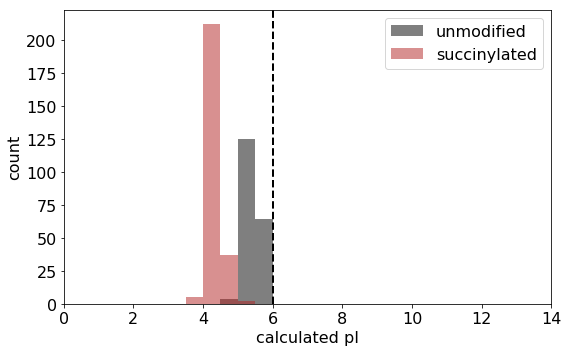

In [14]:
fig, ax = plt.subplots(figsize=(8,5))
native_pi = []
succ_pi = []
for rs in rxn_syst.yield_rxn_syst(output_dir):    
    # collect pIs of all sequences even if reaction is skipped elsewhere
    if rs.skip_rxn is True and rs.UniprotID != '' and rs.UniprotID != None:
        try:
            pI = rs.pI
        except AttributeError:
            print('calculating pI')
            IDs = rs.UniprotID.split(" ")
            total_sequence = ''
            for i in IDs:
                sequence = Uniprot_IO.get_sequence(i)
                total_sequence += sequence
            rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
            rs.save_object(output_dir+rs.pkl)
    
    if rs.UniprotID != '' and rs.UniprotID != None:
        if rs.req_mod == None:
            native_pi.append(rs.pI)
        else:
            succ_pi.append(rs.pI)
        
ax.hist(native_pi,
        facecolor='k',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='unmodified')

ax.hist(succ_pi,
        facecolor='firebrick',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='succinylated')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('calculated pI', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(0, 14)
# plot pI cut-off
ax.axvline(x=param_dict['cutoff_pi'], c='k', lw='2', linestyle='--')
# legend
ax.legend(fontsize=16)

fig.tight_layout()
fig.savefig(output_dir+"pI_dist.pdf",
            dpi=720, bbox_inches='tight')

### Plot pI vs maximum component size

In [15]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


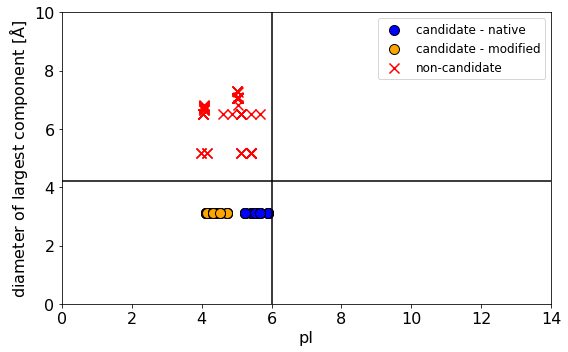

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
        
    if rs.seed_MOF is None:
        continue
    
    if rs.all_fit is True and rs.seed_MOF is True:
        M = 'o'
        if rs.req_mod is not None:
            C = 'orange'
        else:
            C = 'b'
        E = 'k'
    else:
        #if rs.pI < 6 or rs.max_comp_size < 4.2:
        #    print(rs.seed_MOF, rs.all_fit, rs.pkl, rs.pI, rs.max_comp_size)
        #    input('done')
        M = 'x'
        C = 'r'
        E = 'k'
        
    ax.scatter(rs.pI,
               rs.max_comp_size, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E,
           marker='o', 
           alpha=1.0,
           s=100,
           label='candidate - native')
ax.scatter(-100, 100,
           c='orange',
           edgecolors=E,
           marker='o',
           alpha=1,
           s=100,
           label='candidate - modified')
ax.scatter(-100, 100,
           c='r',
           edgecolors=E,
           marker='x',
           alpha=1,
           s=100,
           label='non-candidate')

ax.legend(loc=1, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=param_dict['cutoff_pi'], c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='pI',
                      ytitle='diameter of largest component [$\mathrm{\AA}$]',
                      xlim=(0, 14),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_pI.pdf", dpi=720,
            bbox_inches='tight')

### Plot # of reactions vs threshold value

In [28]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


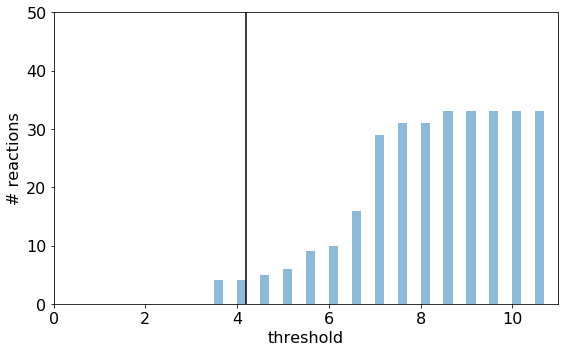

In [49]:
fig, ax = plt.subplots(figsize=(8,5))
max_sizes = []
reaction_reported = [] 
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
    # get list of SMILES of all components
    r_smiles = []
    r_MW = []
    for r in rs.components:
        r_smiles.append(r.SMILES)
        r_MW.append(Descriptors.MolWt(r.mol))
    r_smiles = [x for _, x in sorted(zip(r_MW, r_smiles))]
    if r_smiles in reaction_reported:
        continue
    else:
        reaction_reported.append(r_smiles)
    try:
        if rs.max_comp_size > 0:
            max_sizes.append(rs.max_comp_size)
    except AttributeError:
        pass

    
max_sizes = np.asarray(max_sizes)
counts = []
threshs = np.arange(0.1, 21, 0.5)
for thr in threshs:
    count_above = len(max_sizes[max_sizes < thr])
    counts.append(count_above)
    
ax.bar(threshs, counts, align='center', alpha=0.5, width=0.2)

ax.axvline(x=threshold, c='k')

define_plot_variables(ax,
                      title='',
                      xtitle='threshold',
                      ytitle='# reactions',
                      xlim=(0, 11),
                      ylim=(0, 50))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_threshold.pdf", dpi=720,
            bbox_inches='tight')

### Categorize all molecules in output file

In [19]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])

In [20]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

unique molecule that fits: H2O - DB: SABIO - ID: 40
unique molecule that fits: H2O2 - DB: SABIO - ID: 1909
unique molecule that fits: O2 - DB: SABIO - ID: 1264
unique molecule that fits: NH3 - DB: SABIO - ID: 1268
unique molecule that fits: CO2 - DB: SABIO - ID: 1266
unique molecule that fits: methanol - DB: BKMS - ID: 17790
unique molecule that fits: formaldehyde - DB: BKMS - ID: 16842
unique molecule that fits: Ca2+ - DB: SABIO - ID: 1289
unique molecule that fits: CN- - DB: SABIO - ID: 2269
unique molecule that fits: dioxygen - DB: BKMS - ID: 15379
unique molecule that fits: superoxide - DB: BKMS - ID: 18421
unique molecule that fits: hydron - DB: BKMS - ID: 15378
unique molecule that fits: bromide - DB: BKMS - ID: 15858
unique molecule that fits: hypobromous acid - DB: BKMS - ID: 29249


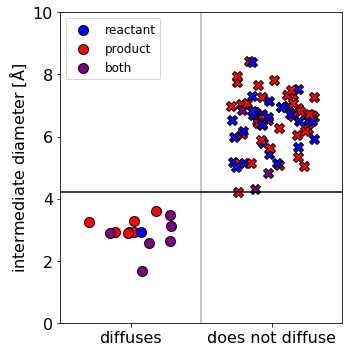

In [21]:
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for idx, row in molecule_output.iterrows():
    mid_diam = row['mid_diam']
    if mid_diam == 0:
        continue
    if mid_diam <= threshold:
        M = 'o'
        E = 'k'
        D = 0.25
        print('unique molecule that fits:', row['name'], 
              '- DB:', row['DB'], '- ID:', row['DB_ID'])
    else:
        M = 'X'
        E = 'k'
        D = 0.75
    
    # set colour based on role
    if row['role'] == 'reactant':
        C = 'b'
    elif row['role'] == 'product':
        C = 'r'
    elif row['role'] == 'both':
        C = 'purple'
    
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='reactant')
ax.scatter(-100, 100,
           c='r', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='product')
ax.scatter(-100, 100,
           c='purple', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='both')

ax.legend(loc=2, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=0.5, c='k', alpha=0.3)
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

In [22]:
molecule_output

,name,iupac_name,DB,DB_ID,SMILE,role,min_diam,mid_diam,max_diam,ratio_1,ratio_2
0,Ferrocytochrome c,NaN,SABIO,1938,CN=C(O)C(N)CSC(C)c1c(C)c2cc3[nH]c(cc4[nH]c(cc5...,both,0.000,0.000,0.000,0.000,0.000
1,H2O,NaN,SABIO,40,O,both,2.492,2.586,3.748,0.347,0.653
2,H2O2,NaN,SABIO,1909,OO,both,2.903,3.112,4.132,0.101,0.984
3,O2,NaN,SABIO,1264,[O],both,2.635,2.639,2.675,0.000,0.000
4,NH3,NaN,SABIO,1268,N,product,2.683,2.928,3.507,0.636,0.636
5,Urea,NaN,SABIO,1798,N=C(N)O,reactant,2.867,5.181,5.775,0.446,0.554
6,CO2,NaN,SABIO,1266,O=C=O,product,2.806,2.916,5.312,0.000,1.000
7,sucrose,NaN,KEGG,17992,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,reactant,0.000,0.000,0.000,0.000,0.000
8,beta-D-fructofuranose,NaN,KEGG,28645,O[CH2:1][C@@:2]1(O)O[C@H:5]([CH2:6]O)[C@@H:4](...,product,5.496,7.048,9.141,0.390,0.791
9,alpha-D-glucose,NaN,KEGG,17925,O[C@H:1]1O[C@H:5]([CH2:6]O)[C@@H:4](O)[C@H:3](...,product,4.942,7.281,8.423,0.408,0.699


### print all reactions that fit

In [47]:
count = 0
reaction_reported = []
# iterate over reaction system files
for rs in rxn_syst.yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
    # get list of SMILES of all components
    r_smiles = []
    r_MW = []
    for r in rs.components:
        r_smiles.append(r.SMILES)
        r_MW.append(Descriptors.MolWt(r.mol))
    r_smiles = [x for _, x in sorted(zip(r_MW, r_smiles))]
    if r_smiles in reaction_reported:
        continue
    else:
        reaction_reported.append(r_smiles)
    if rs.all_fit is True:
        count += 1
        print("New Reaction:")
        rs.print_rxn_system()
        
print("There are", count, "new reactions!")

New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 23680
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: BKMS
Database ID: 8219
-----------------------------------
hydrogen peroxide  (ID: 16240) as reactant
SMILES: OO
methanol  (ID: 17790) as reactant
SMILES: CO
formaldehyde  (ID: 16842) as product
SMILES: C=O
water  (ID: 15377) as product
SMILES: O
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: KEGG
Database ID: R00009
-----------------------------------
hydrogen peroxide  (ID: 16240) as reactant
SMILES: OO
dioxygen  (ID: 15379) as pr

In [21]:
import cirpy

In [26]:
a = cirpy.resolve('ferrocytochrome c555', 'iupac_name')

In [29]:
a.type

AttributeError: 'NoneType' object has no attribute 'type'

# Archive Code

## Brenda Attempts

In [12]:
from IPython.display import clear_output

In [15]:
print('Screen all Enzymes in EC Classes using BRENDA data')
count_done = 0
total_start_time = time.time()
for EC_file in database_names:
    if EC_file != '/home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta':
        continue
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('-----------------------------------------------')
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    # only keep those that pass the pI test
    pi_passed_data = EC_pi_data[EC_pi_data['pi'] < param_dict['cutoff_pi']]
    print('--- ', 
          len(pi_passed_data), 'proteins out of', len(EC_pi_data), 
          'remain, OR', int(len(pi_passed_data)/len(EC_pi_data)*100),
          "% ---")
    EC_no = list(set(EC_pi_data['EC.code']))[0].replace(' ', '').replace(".", "_")
    print('EC:', EC_no.replace("_", "."))
    br_datafile = 'brenda_download_'+EC_no+'.txt'
    # convert br_datafile into dictionary
    br_symbols, br_data = brenda_IO.get_brenda_dict(param_dict['BRENDA_DB_loc']+br_datafile)
    # from here is quite bio-min assay literature specific
    # - although the code can be reused
    # get species of interest from known EC records
    ## when generalizing - we want to remove this for loop
    species_of_interest = EC_set[EC_no.replace('_', '.')]
    for spec in species_of_interest:
        print('species:', spec)
        spec_in_seq, spec_in_br = brenda_IO.is_species_reported(spec, 
                                                                EC_pi_data, 
                                                                br_data, 
                                                                verbose=True)
        # get protein numbers associated with species
        PR_of_int = []
        for i in sorted(br_data['PR']):
            if spec in i.lower():
                # this assumes that the first item of each line is always "#"
                PR_info = i.split("#")[1]            
                if PR_info not in PR_of_int:
                    PR_of_int.append(PR_info)
        print('when you want to go species unspecific you set PR_of_int to None and loop over all.')
        # get reaction systems from BRENDA
        prop_of_int = 'SP'
        list_of_int = br_data[prop_of_int]
        EC_prop_PR_codes = brenda_IO.get_prop_PR_codes(list_of_int)
        value_of_int = {}
        ## when generalizing - we want to remove this for loop
        for PR in PR_of_int:
            if PR in set([j for i in EC_prop_PR_codes.values() for j in i ]):
                print('protein code:', PR, 'has', prop_of_int, 'in BRENDA')
            else:
                print('protein code:', PR, 'does not have', prop, 'in BRENDA')
            values = [list_of_int[i]
                      for i in EC_prop_PR_codes.keys() if PR in EC_prop_PR_codes[i]]
            count = 0
            # iterate over all lines of BRENDA file with PR in SP initial
            for val in values:
                #if '3-(4-hydroxyphenyl)propanoic' not in val:
                #    continue
                print(val)
                print('############################')
                # split val into sections and remove preceding sections to avoid
                # confusion
                PR_sect = val.split("# ")[0]+"# "
                val = val.replace(PR_sect, '')
                rxn_sect = val.split(" (")[0].split(" <")[0]
                val = val.replace(rxn_sect, '')
                meta_sect = val
                # output dictionary
                reaction_system = brenda_IO.Reaction_system(EC_no, prop_of_int, PR, str(count))
                # get all PR associated with rxn system
                # strip value of anything in the first pair of "#" >> as PR codes
                t_assoc_PR = PR_sect.split("#")[1].split(',')
                # check for new lines and split string into list
                reaction_system.assoc_PR = brenda_IO.check_new_lines_and_split(t_assoc_PR)
                # strip value of anything in "(" and ")" >> as meta
                reaction_system.meta = meta_sect
                # split meta info into:
                # references 
                # references for an entry in BRENDA are within "<" and ">"
                t_assoc_refs = val.split(" <")[-1]
                t_assoc_refs = t_assoc_refs.split(">")[0].split(',')
                reaction_system.assoc_refs = brenda_IO.check_new_lines_and_split(t_assoc_refs)
                # reversible?
                # for the "SP" entries - a 'r' enclosed in "{" and "}"
                # implies reversible
                if '{r}' in reaction_system.meta:
                    reaction_system.reversible = True
                # reaction catalysed and reaction type
                reaction_system.extract_general_rxn_info(br_data)

                # make into function -- extract_reactants_products
                # get reactants as before '=' and products as after
                react, prod = rxn_sect.split("=")
                # separate react and prod into molecules by "+"
                r_mol = react.split("+")
                p_mol = prod.split("+")
                # remove preceding and succeeding white space from all molecule names
                r_mol = [i.lstrip().rstrip() for i in r_mol]
                p_mol = [i.lstrip().rstrip() for i in p_mol]
                #####

                # add flags to reaction system for informaton also available in BRENDA
                # no. subunits
                reaction_system.extract_subunit_info(br_data, PR)
                # post translational mods
                reaction_system.extract_PTM(br_data, PR)
                # cofactors
                reaction_system.extract_cofactor_info(br_data, PR)
                # activation cmpds?
                reaction_system.extract_activating_mol(br_data, PR)

                reaction_system.react_mol = r_mol
                reaction_system.prod_mol = p_mol
                
                reaction_system.print_rxn_system()
                input('done?')
                clear_output()
                # output reacion system to file
                # prefix + EC + property + PR code in BRENDA + count of associated files .pkl
                pickle_name = reaction_system.pickle_name
                # pickle reaction system object
                reaction_system.save_object(output_dir+pickle_name)
                count += 1

            break
            if len(values) > 0:
                value_of_int[PR] = values
    count_done += 1
print('--- finished %s EC classes in %s seconds ---' % (count_done, '{0:.2f}'.format(time.time() - total_start_time)))

#12,52# esculetin + H2O2 = ? (#52# demonstration, that esculetin is no
inhibitor, but a substrate of mushroom polyphenol oxidase (PPO) and
horseradish peroxidase (POD) <83>) <28,83>

############################
--------------------------
Reaction system in: RS-1_11_1_7-SP_52_2.pkl
Reaction Catalysed:
['2 phenolic donor + H2O2 = 2 phenoxyl radical of the donor + 2 H2O']
Reaction Type:
['redox reaction', 'oxidation', 'reduction', 'hydroxylation']
--------------------------
Reactants: esculetin + H2O2 -------->
Products: ?
Activating Molecules: melamine OR 2-aminothiazole
--------------------------
No. Sub units = ['?', 'monomer']
Reversible?: None
Co factors?: True
Cofactor Molecules: heme
Post Translational Mods?: ['glycoprotein']
--------------------------
Meta (in full):
 (#52# demonstration, that esculetin is no
inhibitor, but a substrate of mushroom polyphenol oxidase (PPO) and
horseradish peroxidase (POD) <83>) <28,83>

References: ['28', '83']
--------------------------


KeyboardInterrupt: 

In [9]:
file_t = '/home/atarzia/psp/sequence_db/bio_min_dataset/3_1_1_6__BRENDA_sequences_mod.fasta'
temp1 = pi_data[pi_data['fasta_file'] == file_t]
temp2 = temp1[temp1['species'] == ' Vibrio parahaemolyticus V-223/04 ']
print(temp2)

                                                fasta_file acc.code  \
1305091  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2DBW5    
1305092  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2DBW5    
1305123  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2EP46    

                 organism    EC.code                             species  \
1305091   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    
1305092   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    
1305123   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    

            note    pi  modification  category  
1305091   TrEMBL  6.38             0         1  
1305092   TrEMBL  6.38             1         1  
1305123   TrEMBL  5.79             0         0  


In [10]:
temp1.loc[1305123]['species']

' Vibrio parahaemolyticus V-223/04 '

##  load in reaction system

In [38]:
# load in reaction system from pickle file
new_reaction_system = brenda_IO.Reaction_system.load_object(output_dir+pickle_name)

In [39]:
new_reaction_system.print_rxn_system()

--------------------------
Reaction system in: RS-1_11_1_7-SP_52_0.pkl
Reaction Catalysed:
['2 phenolic donor + H2O2 = 2 phenoxyl radical of the donor + 2 H2O']
Reaction Type:
['redox reaction', 'oxidation', 'reduction', 'hydroxylation']
--------------------------
Reactants: guaiacol + H2O2 -------->
Products: tetraguaiacol + H2O
Activating Molecules: melamine OR 2-aminothiazole
--------------------------
No. Sub units = ['?', 'monomer']
Reversible?: None
Co factors?: True
Cofactor Molecules: heme
Post Translational Mods?: ['glycoprotein']
--------------------------
Meta (in full):
(#64# 100% activity <80>; #83# 100% activity with guaiacol at 25 mM
<105>; #44# 74% activity compared to
2,2-azino-bis-(3-ethyl-6-benzothiazolinsulfonate) <82>; #82# shows high
efficiency of interaction with guaiacol at 25 mM <105>; #30# 100%
activity, high efficiency of interaction with guaiacol at 25 mM <105>;
#52# optimal concentrations of guaiacol and H2O2 are 0.5 mM and 0.3 mM,
respectively <139>)
<5,6,

## collect SMILES from common name from Brenda

### CHEMBL

In [43]:
available_resources = [resource for resource in dir(new_client) if not resource.startswith('_')]
print(available_resources)
print(len(available_resources))

# molecule handler
molecule = new_client.molecule
molecule.set_format('json')

# get molecule using unambiguous
m3 = molecule.get('CC(=O)Oc1ccccc1C(=O)O')

# batch queries
records3 = molecule.get(['CNC(=O)c1ccc(cc1)N(CC#C)Cc2ccc3nc(C)nc(O)c3c2',
            'Cc1cc2SC(C)(C)CC(C)(C)c2cc1\\N=C(/S)\\Nc3ccc(cc3)S(=O)(=O)N',
            'CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H]3CCCN3C(=O)C(CCCCN)CCCCN)C(C)(C)C)C(=O)O'])

['activity', 'assay', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'document_term', 'drug', 'drug_indication', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_prediction', 'target_relation', 'tissue', 'xref_source']
33


In [44]:
from chembl_webresource_client.new_client import new_client
molecule = new_client.molecule
res = molecule.search('vinylacetyl-CoA')  # 'viagra')
# guaiacol

In [45]:
print(res[0]['molecule_chembl_id'])
print(res[0]['molecule_structures']['canonical_smiles'])
print('there are', len(res), 'top search candidates:')
for i in range(len(res)):
    print('option:', i, 'name:', res[i]['pref_name'])
    print([res[i]['molecule_synonyms'][j]['synonyms'] for j in range(len(res[i]['molecule_synonyms']))])

TypeError: 'NoneType' object is not subscriptable